# Impact of COVID-19 on U.S. Financial Markets: A Statistical and Predictive Analysis

## Project Overview
This project aims at conducting a Comparative Analysis of various asset metrics due to the impacts of the COVID-19's pandemic on the performance of the US financial markets during a specific period. We will briefly introduce the analysis and outline its objectives in the following sub-sections:
### Introduction:
COVID-19 pandemic brought about adverse effects to the US financial market. This cut across different asset classes over the period. The analysis in this notebook analyzes these impacts while considering the different phases of the pandemic's duration i.e., Pre-Covid, During-Covid and Post-Covid eras. The asset classes and their respective individual asset chosen for this analysis are the following:
- Equities (S&P 500),
- Commodities (Crude oil and Gold),
- Currencies (USD/EUR),
- Cryptocurrencies (Bitcoin), and
- Bonds (US Treasury yield - 10-year)

### Objectives:
1. Extraction of the asset price's data over the specified period for the selected asset classes.
2. Data cleaning and preparation for analysis in the subsequent steps.
3. Perform Exploratory Data Analysis to visualize and derive insights from trends.
4. Perform Hypothesis tests for asset returns, volatility differences and cross-asset correlations.
5. Predictive modeling and volatility assessment using ARIMA and GARCH models, respectively.
6. Proposing the developed portfolio strategies for systemic risk mitigation.
7. Summarizing findings and recommendations.

The stated objectives will form the sections of our notebook. Before we proceed with covering the objectives, we will first all ten necessary libraries.


In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.1 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# from arch import arch_model
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Configure plotting
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Data Extraction
We need the data on which we will be performing the analysis. In this section, we will fetch the specific asset prices data for the required period.

In [ ]:
# Fetching historical data for the selected asset classes
# 1. Equities: S&P 500 (^GSPC)
# 2. Commodities: Crude Oil (CL=F), Gold (GL=F)
# 3. Currencies: USD/EUR (EURUSD=X)
# 4. Cryptocurrencies: Bitcoin (BTC-USD)
# 5. Bonds: US Treasury 10-Year (^TNX)


# Setting date ranges for the three periods
PRE_COVID_START = "2017-01-01"
PRE_COVID_END = "2019-12-31"
DURING_COVID_START = "2020-01-01"
DURING_COVID_END = "2021-12-31"
POST_COVID_START = "2022-01-01"
POST_COVID_END = "2024-12-31"

assets = {
    "Equities (S&P 500)": "^GSPC",
    "Crude Oil": "CL=F",
    "Gold": "GC=F",
    "USD/EUR": "EURUSD=X",
    "Bitcoin": "BTC-USD",
    "US Treasury 10-Year": "^TNX"
}

# Download data using yfinance
data = {}
for asset, ticker in assets.items():
    df = yf.download(ticker, start=PRE_COVID_START, end=POST_COVID_END)
    data[asset] = df.loc[:, 'Close']
    print(f"Downloaded data for {asset}")

# Convert to a unified DataFrame
df_prices = pd.concat(data, axis=1)
df_prices.columns = assets.keys()

# Handle missing values
df_prices.dropna(inplace=True)

# Preview the data
df_prices.head()

[*********************100%***********************]  1 of 1 completed


Downloaded data for Equities (S&P 500)


[*********************100%***********************]  1 of 1 completed


Downloaded data for Crude Oil


[*********************100%***********************]  1 of 1 completed


Downloaded data for Gold


[*********************100%***********************]  1 of 1 completed


Downloaded data for USD/EUR


[*********************100%***********************]  1 of 1 completed


Downloaded data for Bitcoin


[*********************100%***********************]  1 of 1 completed


Downloaded data for US Treasury 10-Year


Equities (S&P 500)  Crude Oil         Gold   USD/EUR      Bitcoin  \
Date                                                                            
2017-01-03         2257.830078  52.330002  1160.400024  1.046003  1043.839966   
2017-01-04         2270.750000  53.259998  1163.800049  1.041992  1154.729980   
2017-01-05         2269.000000  53.759998  1179.699951  1.050089  1013.380005   
2017-01-06         2276.979980  53.990002  1171.900024  1.060592   902.200989   
2017-01-09         2268.899902  51.959999  1183.500000  1.053186   902.828003   

            US Treasury 10-Year  
Date                             
2017-01-03                2.450  
2017-01-04                2.452  
2017-01-05                2.368  
2017-01-06                2.418  
2017-01-09                2.376

## 2. Data Preprocessing
The extracted data is cleaned and prepared for analysis in this step. We will handle the missing prices for our assets of choice, split the dataset into the three periods as well Compute the asset's returns.

In [ ]:
# Calculate daily returns & handling NaNs
returns = df_prices.pct_change().dropna()

# Introduce `Period` column to the returns dataframe
returns["Period"] = pd.cut(returns.index,
                           bins=[pd.Timestamp(PRE_COVID_START), pd.Timestamp(PRE_COVID_END),
                                 pd.Timestamp(DURING_COVID_END), pd.Timestamp(POST_COVID_END)],
                           labels=["Pre-COVID", "During-COVID", "Post-COVID"])
returns.sample(10)

Equities (S&P 500)  Crude Oil      Gold   USD/EUR   Bitcoin  \
Date                                                                      
2021-10-05            0.010525   0.016877 -0.003737  0.000964  0.048906   
2018-06-20            0.001712   0.017673 -0.003449 -0.003627  0.000976   
2021-05-25           -0.002125   0.000303  0.007163  0.002577 -0.007848   
2024-12-26           -0.000406  -0.006847  0.007176 -0.000603 -0.029192   
2018-09-07           -0.002213  -0.000295 -0.003590 -0.001301 -0.009511   
2022-08-05           -0.001626   0.005308 -0.008722  0.008875  0.029091   
2021-10-29            0.001949   0.009178 -0.010324  0.007197  0.026489   
2019-01-10            0.004518   0.004393 -0.003568  0.008631 -0.088314   
2019-01-31            0.008597  -0.008114  0.007481  0.004572 -0.008143   
2024-11-20            0.000022  -0.007494  0.008032  0.001199  0.021612   

            US Treasury 10-Year        Period  
Date                                           
2021-10-05             0.032411  During-COVID  
2018-06-20             0.012098     Pre-COVID  
2021-05-25            -0.027363  During-COVID  
2024-12-26            -0.002614    Post-COVID  
2018-09-07             0.021883     Pre-COVID  
2022-08-05             0.061285    Post-COVID  
2021-10-29            -0.007015  During-COVID  
2019-01-10             0.001100     Pre-COVID  
2019-01-31            -0.022263     Pre-COVID  
2024-11-20             0.006166    Post-COVID

## 3. Exploratory Data Analysis (EDA)
In our exploration of this dataset, we aim to visualize and understand the trends. We will plot and assess the returns and volatility time series, Compute and visualize cross-asset correlations using heatmaps, and Perform a comparison of return distributions using box plots.

### Analysis of Returns.

We will begin with analyzing the returns for the different assets over the period.

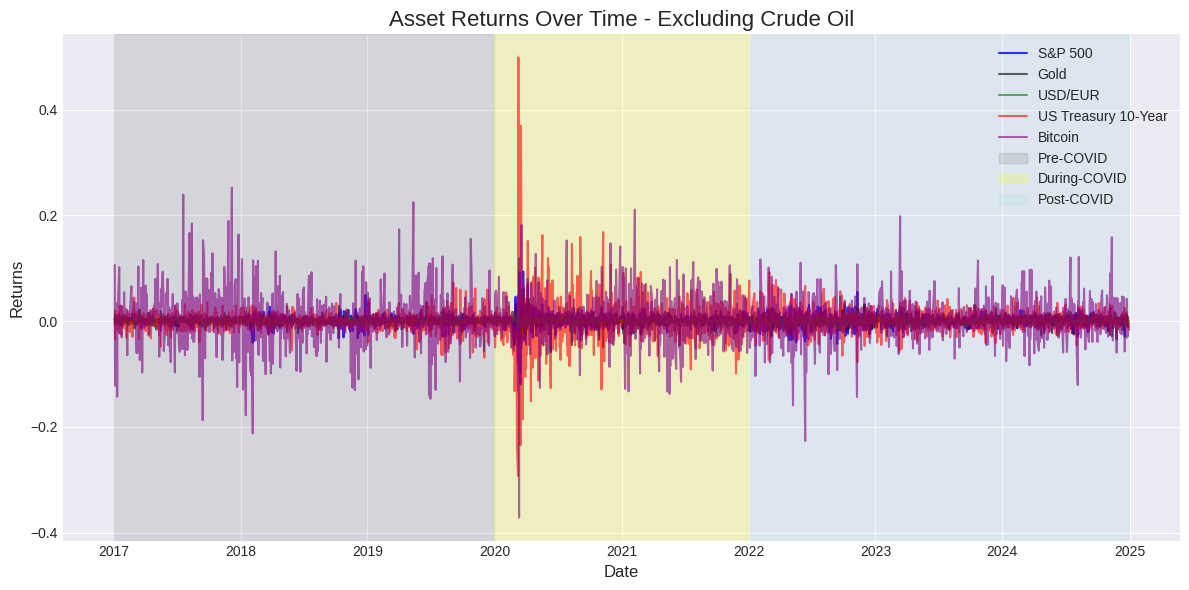

In [ ]:
# Improved plot
plt.figure(figsize=(12, 6))

# Plot each asset class with unique colors and labels
plt.plot(returns.index, returns['Equities (S&P 500)'], label='S&P 500', color='blue', alpha=0.8)
# plt.plot(returns.index, returns['Crude Oil'], label='Crude Oil', color='orange', alpha=0.6)
plt.plot(returns.index, returns['Gold'], label='Gold', color='black', alpha=0.6)
plt.plot(returns.index, returns['USD/EUR'], label='USD/EUR', color='green', alpha=0.6)
plt.plot(returns.index, returns['US Treasury 10-Year'], label='US Treasury 10-Year', color='red', alpha=0.6)
plt.plot(returns.index, returns['Bitcoin'], label='Bitcoin', color='purple', alpha=0.6)

# Mark the periods using shaded regions
plt.axvspan("2017-01-01", "2020-01-01", color='gray', alpha=0.2, label='Pre-COVID')
plt.axvspan("2020-01-01", "2021-12-31", color='yellow', alpha=0.2, label='During-COVID')
plt.axvspan("2022-01-01", "2024-12-31", color='lightblue', alpha=0.2, label='Post-COVID')

# Add title, legend, and axis labels
plt.title("Asset Returns Over Time - Excluding Crude Oil", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

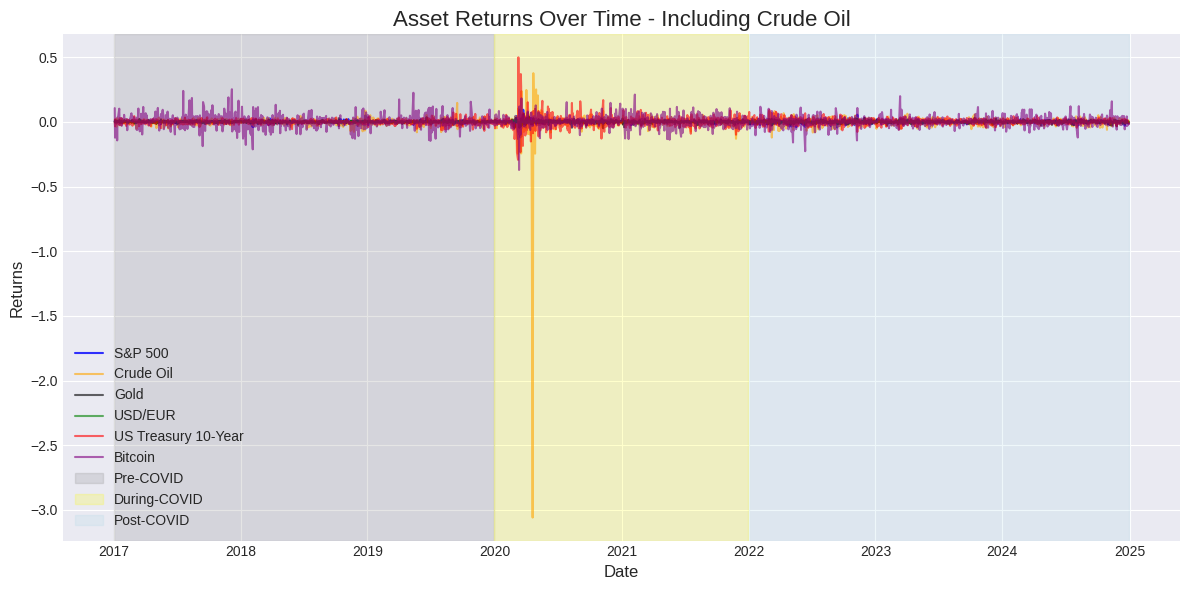

In [ ]:
# Improved plot
plt.figure(figsize=(12, 6))

# Plot each asset class with unique colors and labels
plt.plot(returns.index, returns['Equities (S&P 500)'], label='S&P 500', color='blue', alpha=0.8)
plt.plot(returns.index, returns['Crude Oil'], label='Crude Oil', color='orange', alpha=0.6)
plt.plot(returns.index, returns['Gold'], label='Gold', color='black', alpha=0.6)
plt.plot(returns.index, returns['USD/EUR'], label='USD/EUR', color='green', alpha=0.6)
plt.plot(returns.index, returns['US Treasury 10-Year'], label='US Treasury 10-Year', color='red', alpha=0.6)
plt.plot(returns.index, returns['Bitcoin'], label='Bitcoin', color='purple', alpha=0.6)

# Mark the periods using shaded regions
plt.axvspan("2017-01-01", "2020-01-01", color='gray', alpha=0.2, label='Pre-COVID')
plt.axvspan("2020-01-01", "2021-12-31", color='yellow', alpha=0.2, label='During-COVID')
plt.axvspan("2022-01-01", "2024-12-31", color='lightblue', alpha=0.2, label='Post-COVID')

# Add title, legend, and axis labels
plt.title("Asset Returns Over Time - Including Crude Oil", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

**Remarks:**

In the above, we visualize the daily returns of the different financial assets over the different periods of the pandemic colored distinctly, i.e. pre-COVID (gray), During-COVID (yellow), and post-COVI (blue).

First, we observe that in the pre-COVID Era, the returns of these assets appear to be stable, compared to the later periods. We have no systemic disruptions and consequently the market volatility remains normal.

The next period, During-COVID the assets experience spikes in the return levels, especially around early 2020. Notably, crude oil experienced excessive downward spike during this period. Additionally, other assets such as S&P 500, US Treasury yield and Bitcoin experienced an increased fluctuation in returns over the same period. This implies that during such systemic crises, the asset that previously correlated weakly may tend to move together, increasing their correlations. On the other hand, the assets considered as safe haven, such as Gold tend to perform with minimal fluctuation.

Eventually in the post-COVID period, the assets experience lower fluctuations in the return levels as compared to those during the pandemic. However, these fluctuations are higher compared to those in the period before the pandemic. Also, Bitcoin maintains a high fluctuation in returns throughout the three periods.


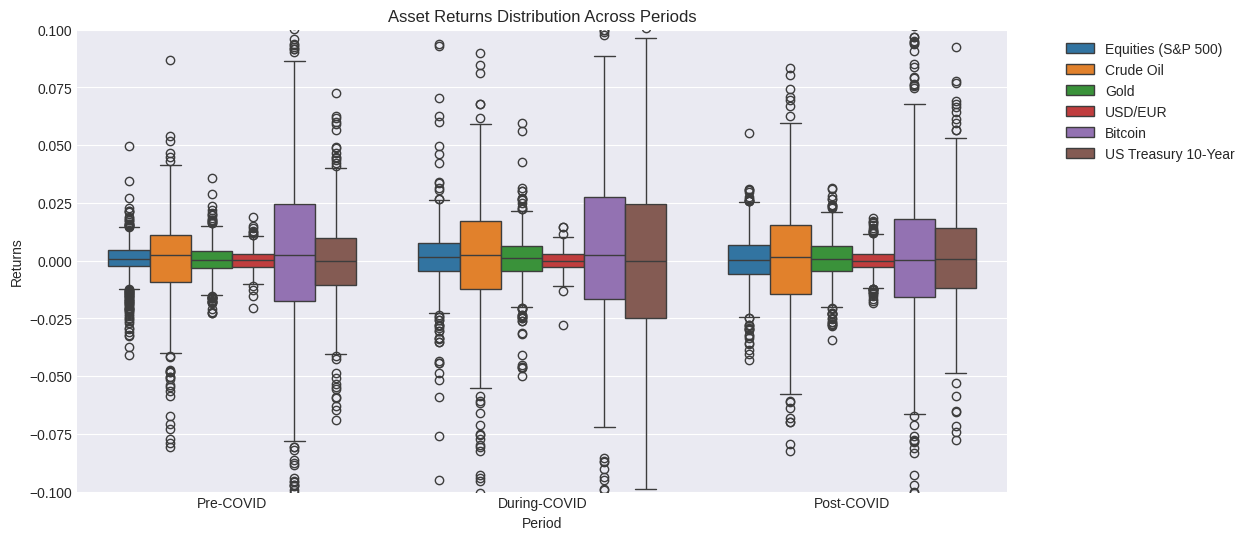

In [ ]:
plt.figure(figsize=(12, 6))

# Reshape data for seaborn boxplot
melted_returns = returns.melt(id_vars=["Period"], var_name="Asset", value_name="Returns")

# --- Boxplot of returns ---
sns.boxplot(x="Period", y="Returns", hue="Asset", data=melted_returns)
plt.ylim(-0.1, 0.1)  # Set limit to reduce extreme outliers' impact
plt.title("Asset Returns Distribution Across Periods")
plt.xlabel("Period")
plt.ylabel("Returns")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Remarks:**

To further understand the distribution of the financial assets returns over the specified periods, we display the above box plot. During the pandemic period, we observe increased returns fluctuation that evidenced by the wider interquartile ranges (IQRs), and more frequent outliers. In contrast, the IQRs prior to the pandemic are narrower, implying normal market conditions. The period that follows the pandemic shows wider IQRs than the ones before the pandemic, but not as wide as those during the pandemic period.

Focusing on the observations on specific assets, it can be seen that Equities (S&P) have the highest dispersion in returns during the pandemic period. This remains relatively higher than the dispersion seen before the pandemic, but lower than that seen during the pandemic. For crude oil, we observe a wide return distribution during the pandemic, with high return fluctuations even after the pandemic. Gold returns maintain constant levels over the periods with mild increase during the pandemic. Bitcoin maintains a wider range of returns across the periods, compared to other assets. USD/EUR returns have experienced a minimal variation across the periods with slightly wider IQR during the pandemic. Finally, the US Treasury 10-year bond shows a wider IQR during the pandemic and retains a less wide IQR after the pandemic.


### Analysis of Volatility.

In this section, we will analyze the volatility behavior for the assets across the periods.

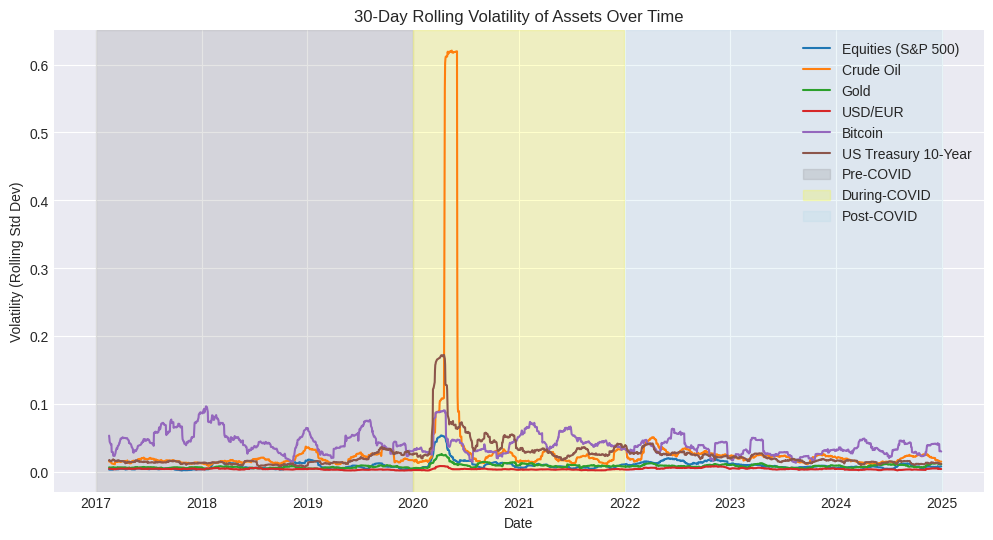

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define rolling window for volatility calculation (e.g., 30-day moving standard deviation)
ROLLING_WINDOW = 30

# Compute rolling volatility (standard deviation) for each asset
volatility = returns.iloc[:, :-1].rolling(window=ROLLING_WINDOW).std()

# Add the Period column back to volatility dataframe
volatility["Period"] = returns["Period"]

# Aggregate volatility statistics by period
volatility_by_period = volatility.groupby("Period").mean()

# --- Visualization: Rolling Volatility Over Time ---
plt.figure(figsize=(12, 6))
for asset in returns.columns[:-1]:  # Excluding the Period column
    plt.plot(volatility.index, volatility[asset], label=asset)


# Mark the periods using shaded regions
plt.axvspan("2017-01-01", "2020-01-01", color='gray', alpha=0.2, label='Pre-COVID')
plt.axvspan("2020-01-01", "2021-12-31", color='yellow', alpha=0.2, label='During-COVID')
plt.axvspan("2022-01-01", "2024-12-31", color='lightblue', alpha=0.2, label='Post-COVID')

plt.title(f'{ROLLING_WINDOW}-Day Rolling Volatility of Assets Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (Rolling Std Dev)')
plt.legend()
plt.show()


**Remarks:**

In the above plot, we visualize the 30-day rolling volatility of the assets across the three periods.

During the period prior to the pandemic, majority of these assets experienced lower volatility levels, apart from bitcoin. Bitcoin has had persistent volatility spikes over the period. The US Treasury 10-year yield experienced relatively stable volatility over this period.

The plot shows how the pandemic caused a large volatility spike. Notably, crude oil experienced a massive spike at the onset of 2020. Also, S&P 500 and Bitcoin assets experienced a sharp volatility rise around the same period though not as much as crude oil.

For period after the pandemic, we observe that most of the asset’s volatility are higher than during the pre-pandemic period, but lower than during the pandemic period. A comparison among assets indicate volatility levels of crude oil and bitcoin remains high.

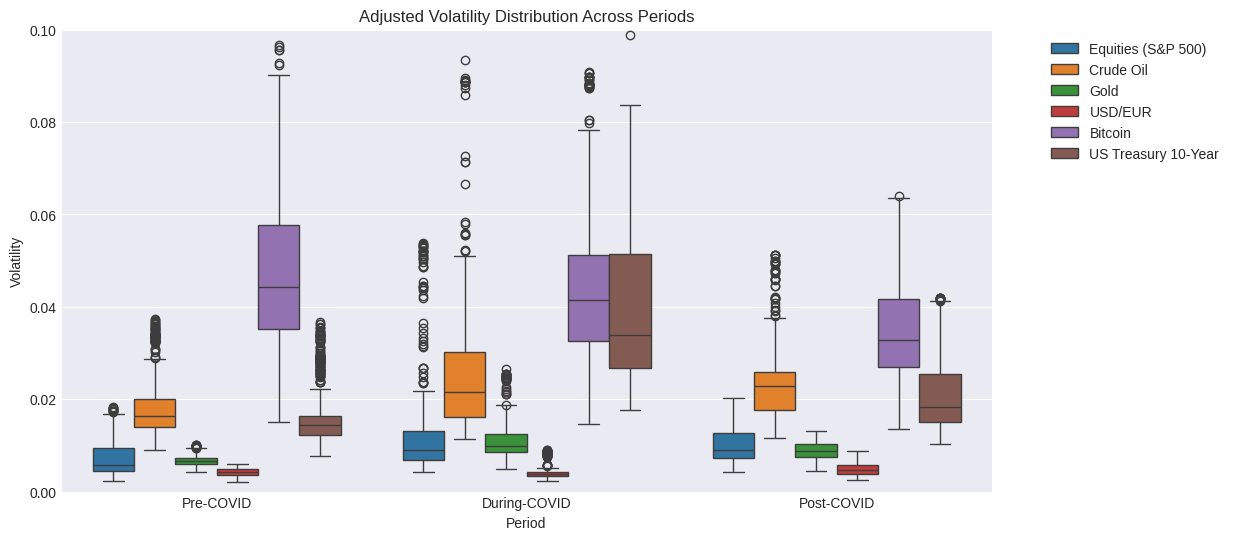

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Reshape data for seaborn boxplot
melted_volatility = volatility.melt(id_vars=["Period"], var_name="Asset", value_name="Volatility")

# --- Boxplot with Y-axis limit to reduce effect of outliers ---
sns.boxplot(x="Period", y="Volatility", hue="Asset", data=melted_volatility)
plt.ylim(0, 0.1)  # Set limit to reduce extreme outliers' impact
plt.title("Adjusted Volatility Distribution Across Periods")
plt.xlabel("Period")
plt.ylabel("Volatility")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Remarks:**

The boxplot visualization above shows then distribution of the rolling volatility for different assets across the three periods.

During the pre-pandemic period, most of the assets experienced a lower volatility with gold and USD/EUR displaying a stable volatility. Among the assets, bitcoin had the highest volatility levels even during this period.

During the pandemic period, bitcoin and US Treasury 10-year assets that experienced the largest volatility increases. Crude oil experienced a notable increase in the range of its volatility. Additionally, there are increased frequency of outliers during this period of crisis.

After the pandemic, the volatility levels declined though they are still higher than pre-pandemic levels. we still observe wider ranges in the bitcoin, crude oil and US Treasury 10-year assets distribution over this period. On the other hand, gold and USD/EUR maintain low volatility levels.

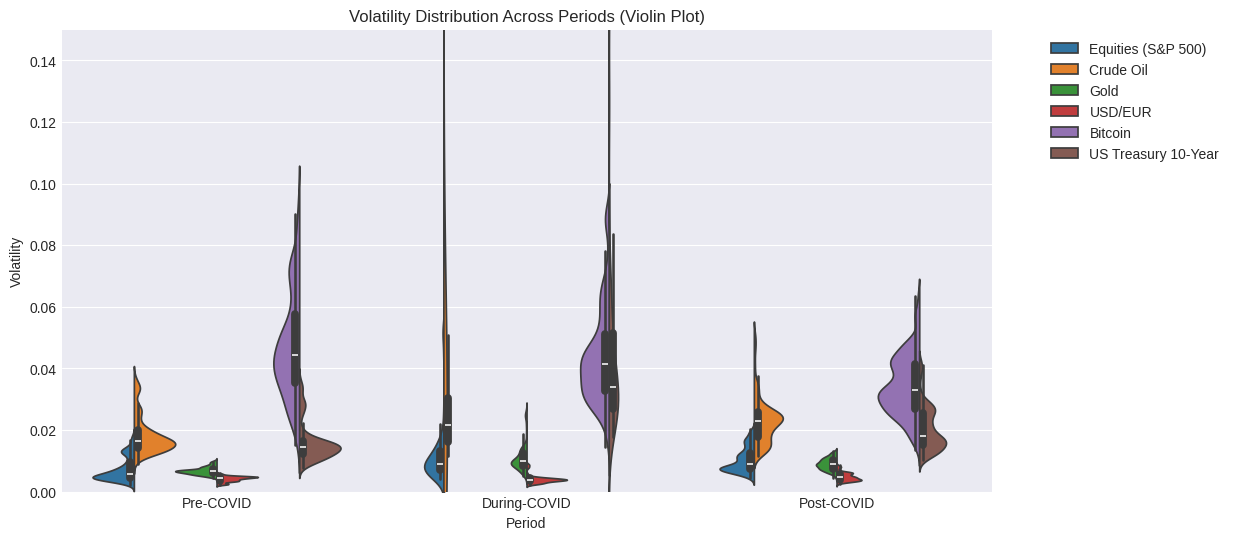

In [ ]:
# --- Alternative: Violin Plot for Better Distribution Visibility ---
plt.figure(figsize=(12, 6))
sns.violinplot(x="Period", y="Volatility", hue="Asset", data=melted_volatility, split=True)
plt.ylim(0, 0.15)
plt.title("Volatility Distribution Across Periods (Violin Plot)")
plt.xlabel("Period")
plt.ylabel("Volatility")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Remarks:**

To better understand the volatility distribution of these assets across the three periods, we included a violin plot above. In contrast to box plot, this visualization can provide more information on spread and density of volatility. For this reason, we can easily note at what points are the volatility values more concentrated.

Just like in our prior visualizations, the above plot shows that the volatility of the assets in the pre-pandemic period was relatively consistent and lower, indicated by the concentrated distributions. Gold and USD/EUR volatilities were the least while bitcoin produced the highest volatility.

The distribution in the pandemic period tends to be much spread for each of the assets, implying higher volatility levels. Bitcoin and US Treasury 10-year display a high volatility spread, while crude oil exhibiting an extreme volatility with its long upper tail. Furthermore, S&P 500 realized an increased volatility, though not as much as for crude oil and bitcoin.

We observe a decreased volatility in the post-pandemic period for the assets, but higher levels than the pre-pandemic period. Bitcoin and US Treasury 10-year retains a high volatility in this period, as well as crude oil.

### Cross-Asset Correlations Analysis.

#### (a). Visualizing Cross-Asset Correlation Across Periods:

To compare asset correlations across periods, we need to:

Compute the correlation matrix for each period separately.
Visualize the correlation matrices using heatmaps for comparison.
Highlight changes in correlations across periods.

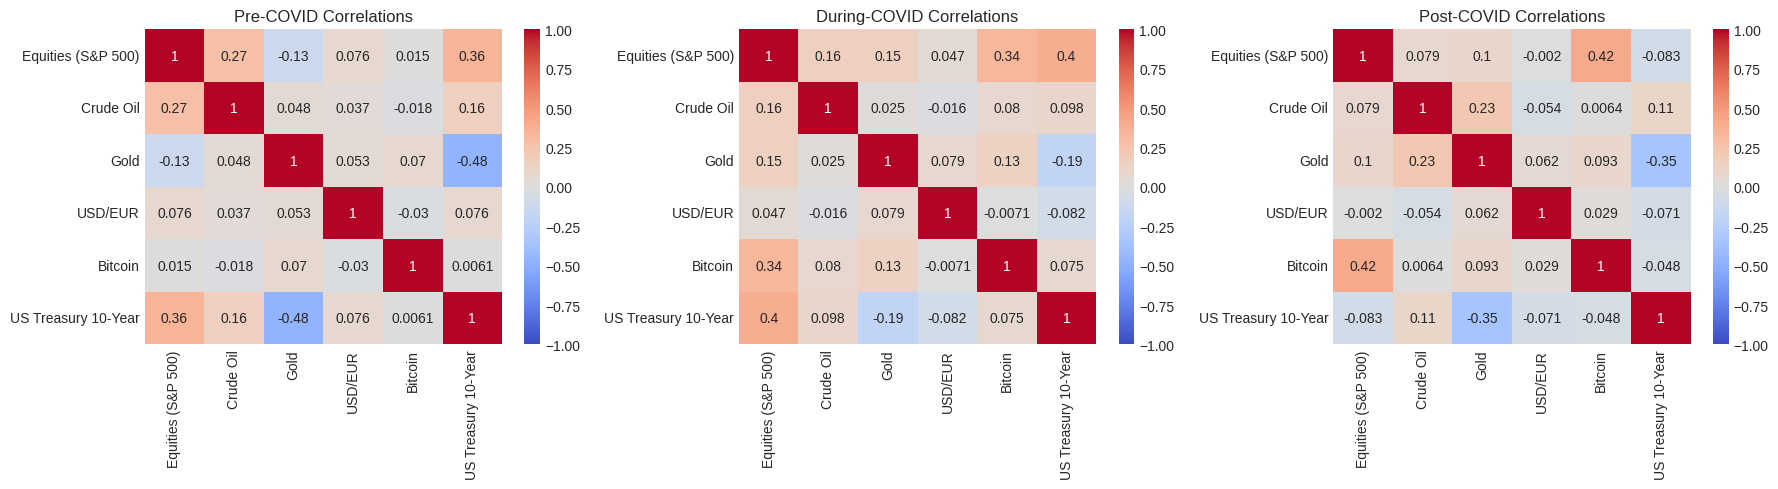

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define unique periods
periods = ["Pre-COVID", "During-COVID", "Post-COVID"]

# Set up figure layout for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Generate and plot correlation heatmap for each period
for i, period in enumerate(periods):
    corr_matrix = returns[returns["Period"] == period].iloc[:, :-1].corr()  # Compute correlation matrix
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[i])  # Heatmap
    axes[i].set_title(f"{period} Correlations")

plt.tight_layout()
plt.show()


**Remarks:**

We use correlation heatmap visualization to investigate the relationship between the different asset classes. In the above, we visualize this for the three different periods. The correlation values range from -1 to +1, with each representing strong negative and strong positive correlations respectively. A correlation of 0 implies lack of relationship between the movement of the two assets. Higher correlation values mean that the assets move together while negative correlation means they move in opposite directions.

During the pre-pandemic period, we observe a mild positive correlation of 0.27 between S&P 500 and crude oil indicating that these assets move slightly move together.  Gold and US Treasury 10-year have a strong negative correlation, of -0.48, implying the opposite movements of the two assets. The correlation between bitcoin and the rest of the assets is very low suggesting that it moves independently from the other assets. US Treasury and S&P 500 indicate a moderate positive correlation of 0.36.

The correlation between bitcoin and S&P 500 indicates a strong positive correlation of 0.34 during the pandemic period. We also observe a strong correlation between US Treasury 10-year and S&P 500 of 0.40. the correlations between gold and US Treasury 10-year (-0.19) and that between crude oil and S&P (0.16) are notably weak.

In the post-pandemic period, the correlation between bitcoin and S&P 500 (0.42) is strong and positive while for gold and US Treasury 10-year (-0.35) is strong and negative. The correlations between crude oil and S&P 500 (0.079) and US Treasury 10-year and S&P (-0.083) are weak.

#### (b). Analyzing Major Shifts in Rolling Correlations Over Time

The rolling correlations are computed for a chosen window of 60 days. This will allow us to detect major shifts in the correlations. This will be achieved through computation of the dynamic rolling correlation for a pair of assets and visualize for the three periods.

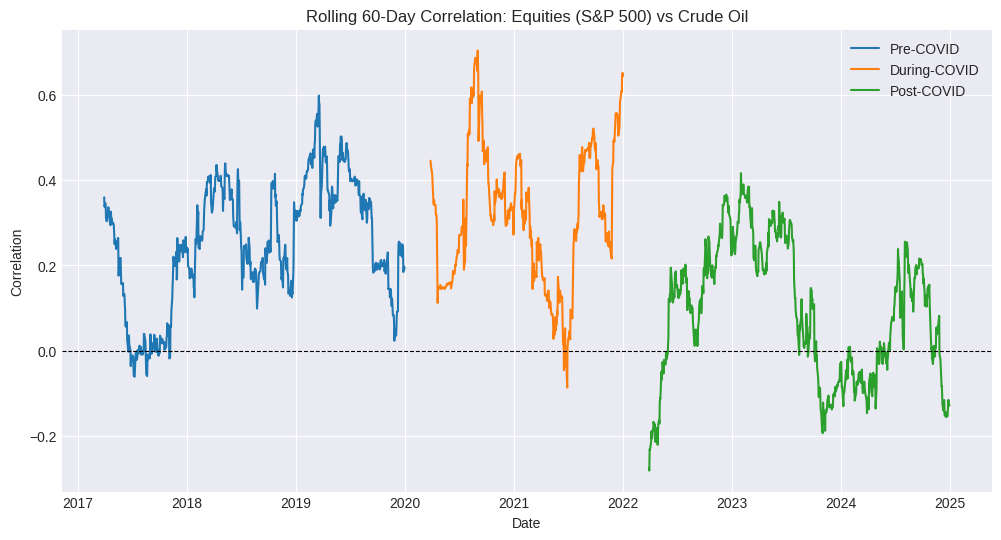

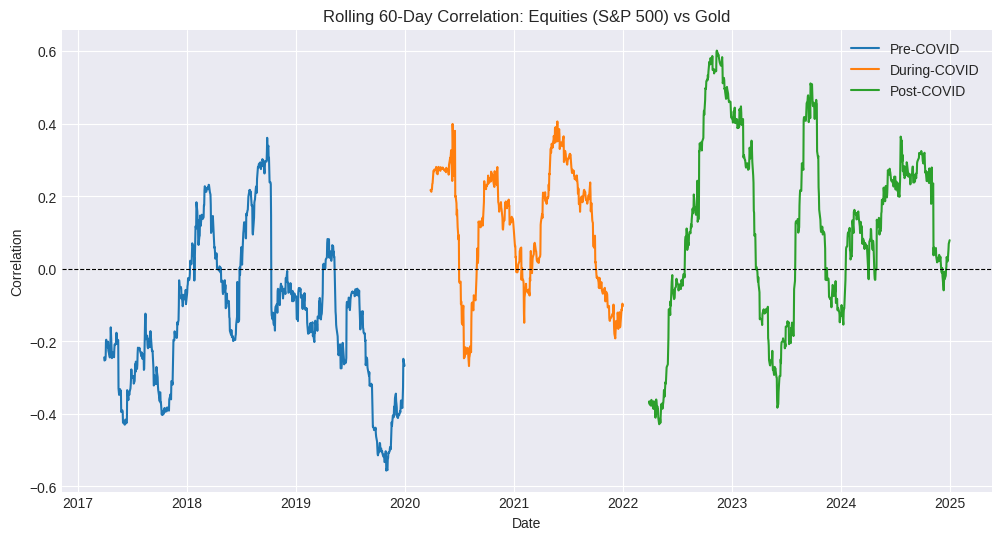

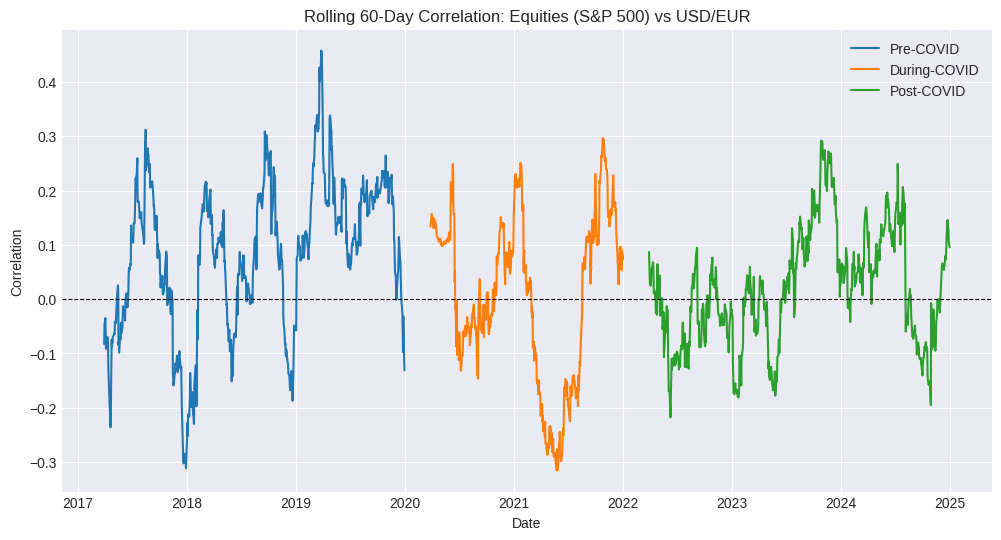

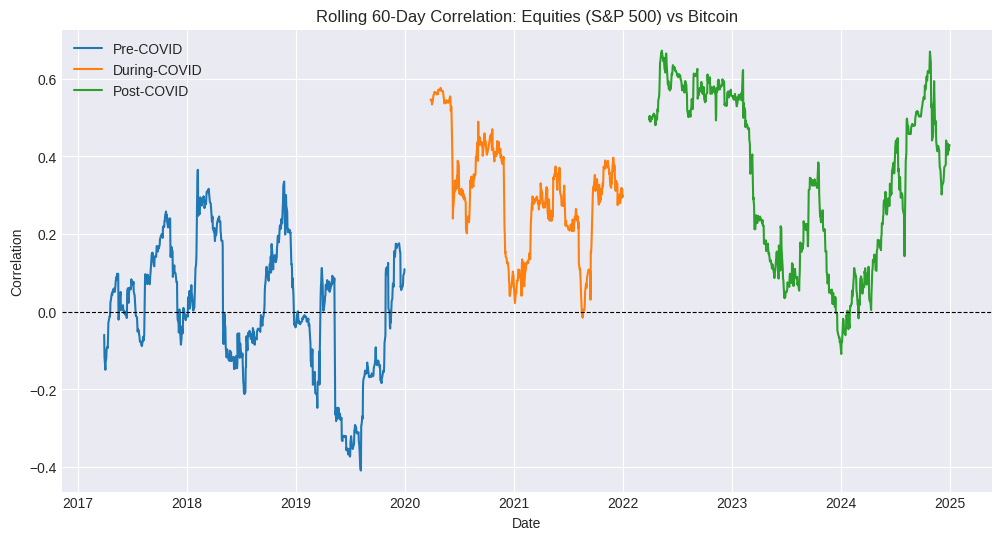

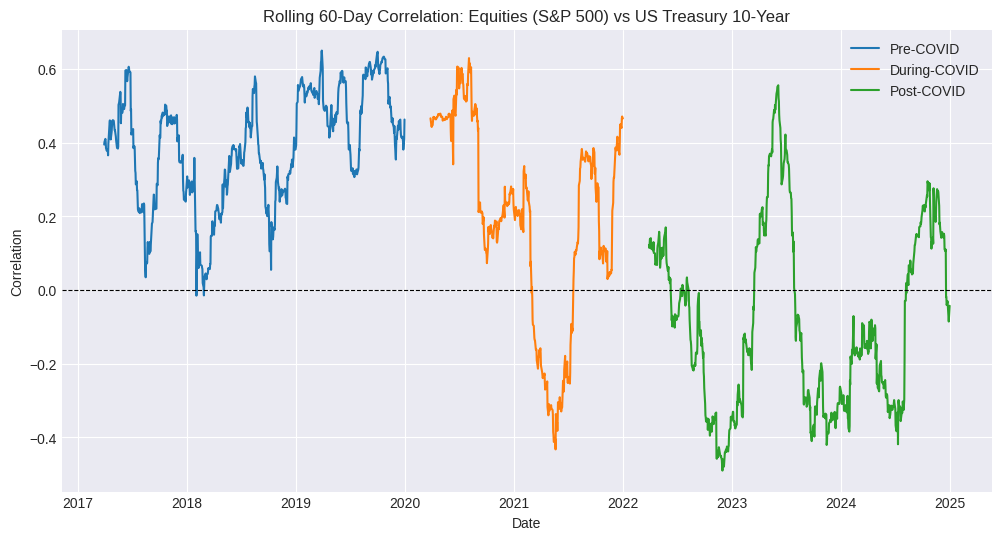

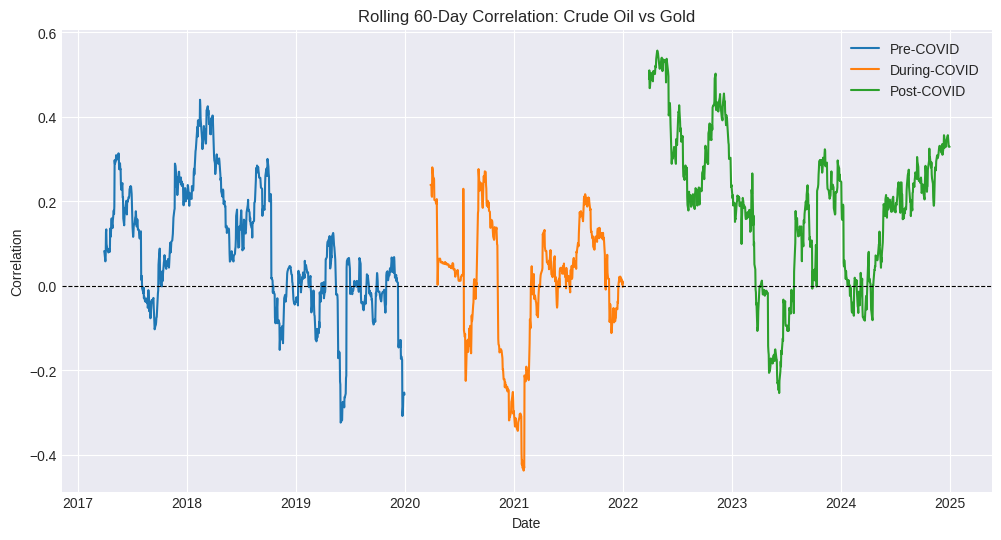

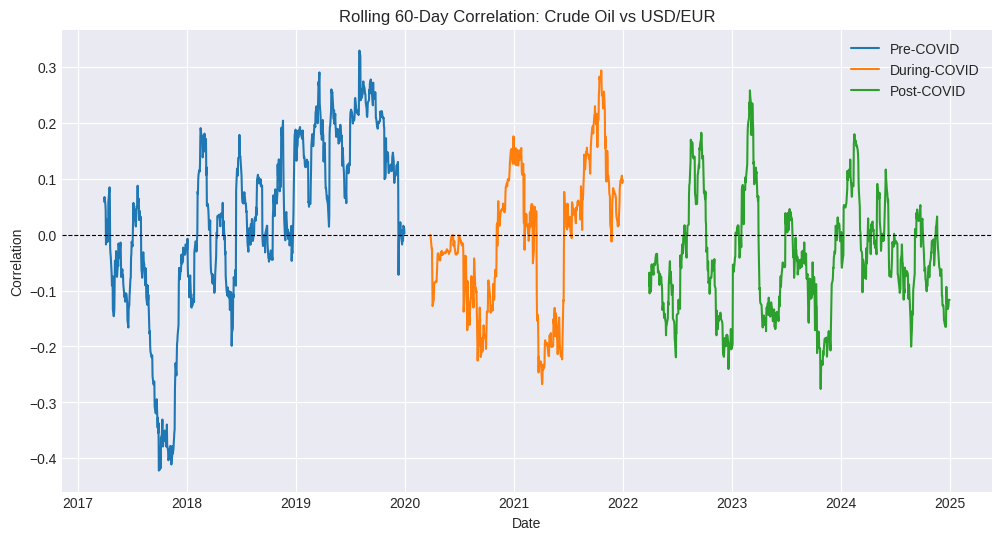

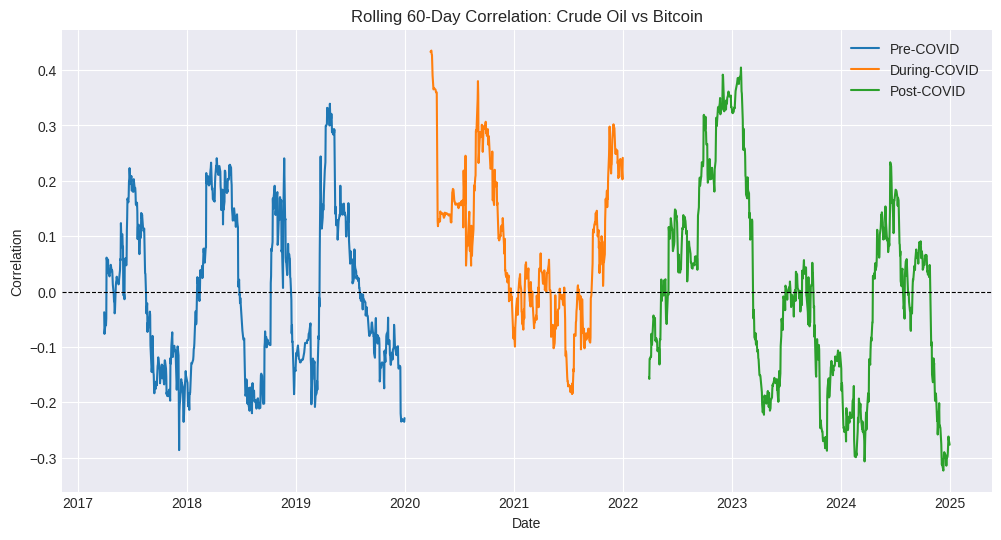

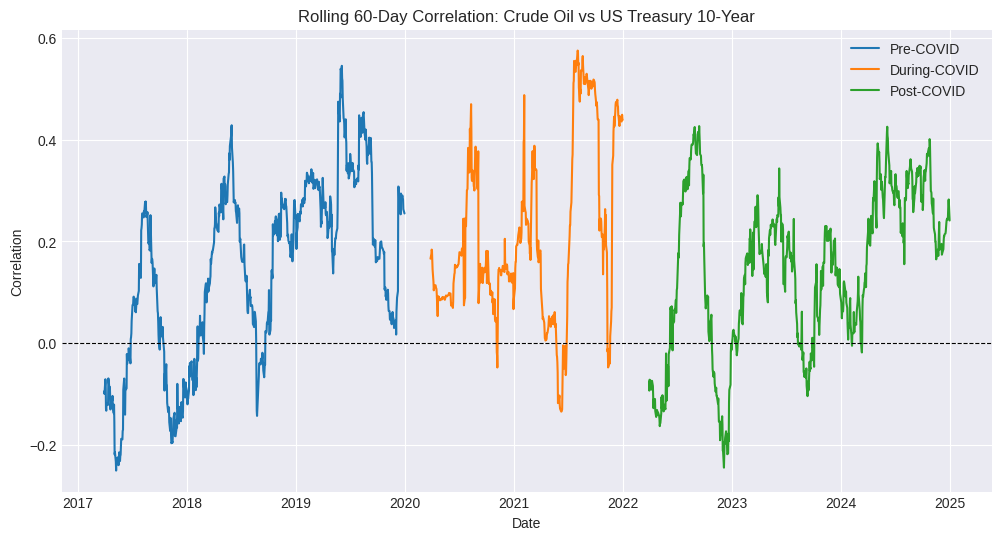

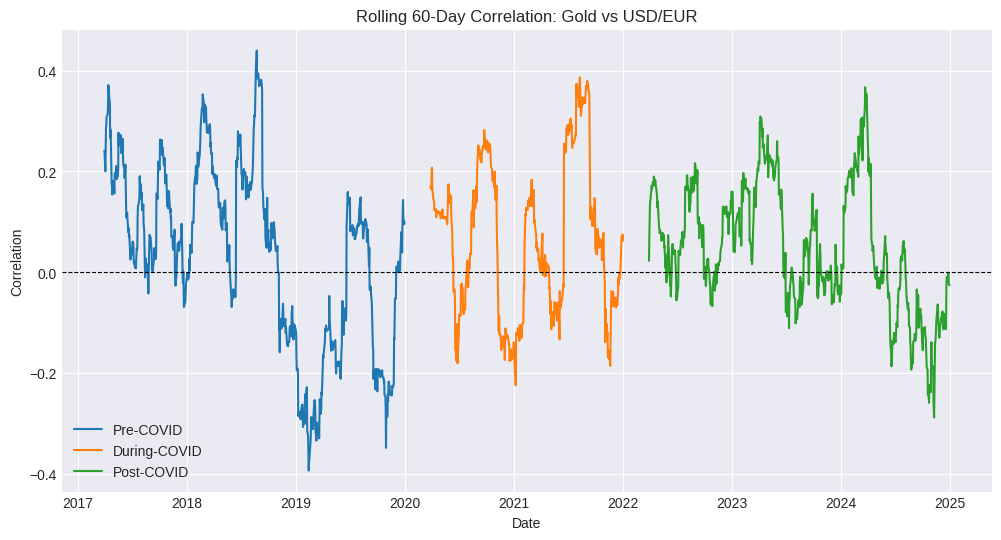

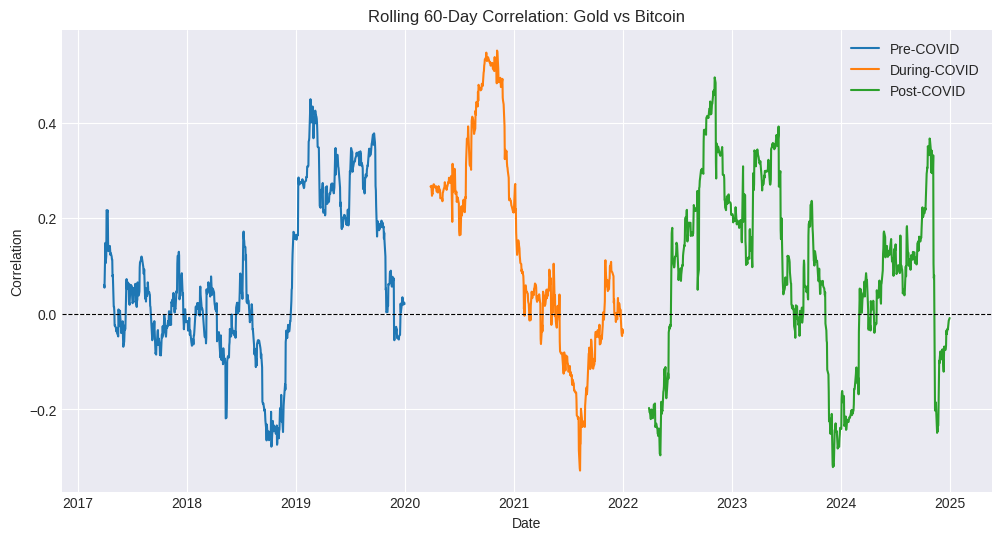

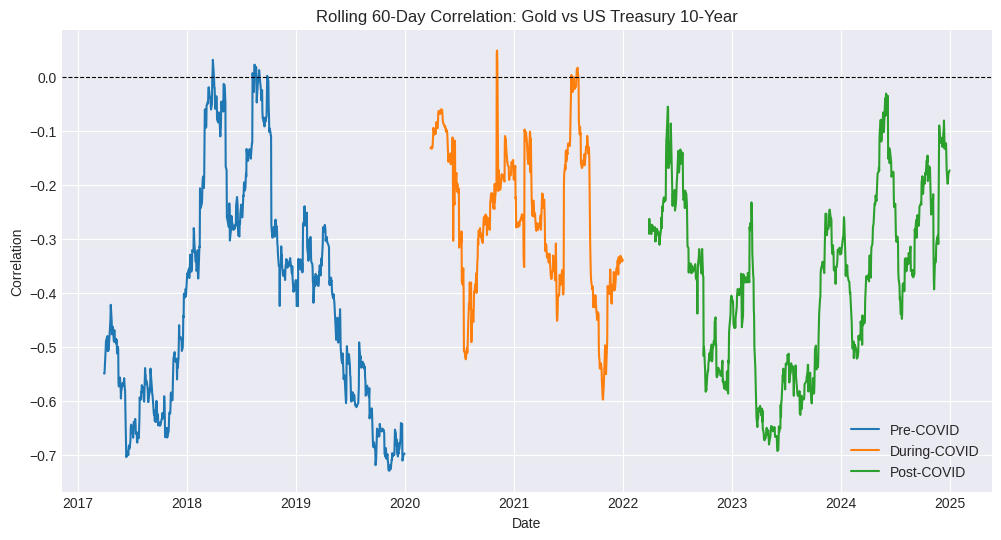

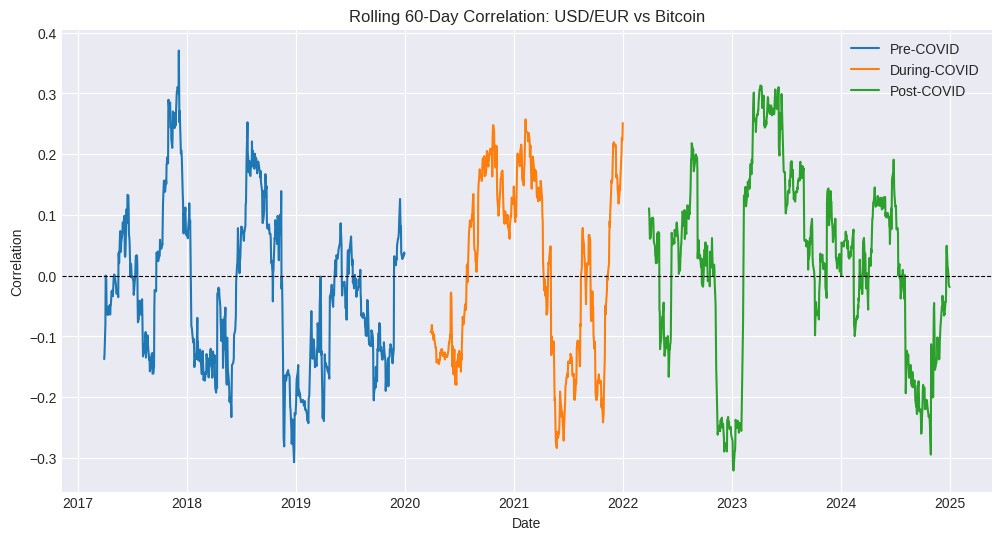

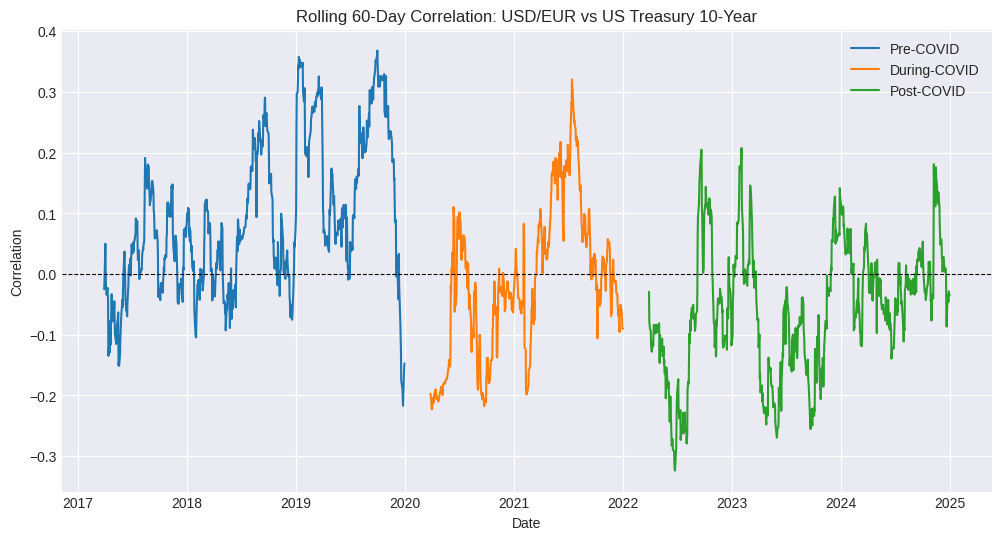

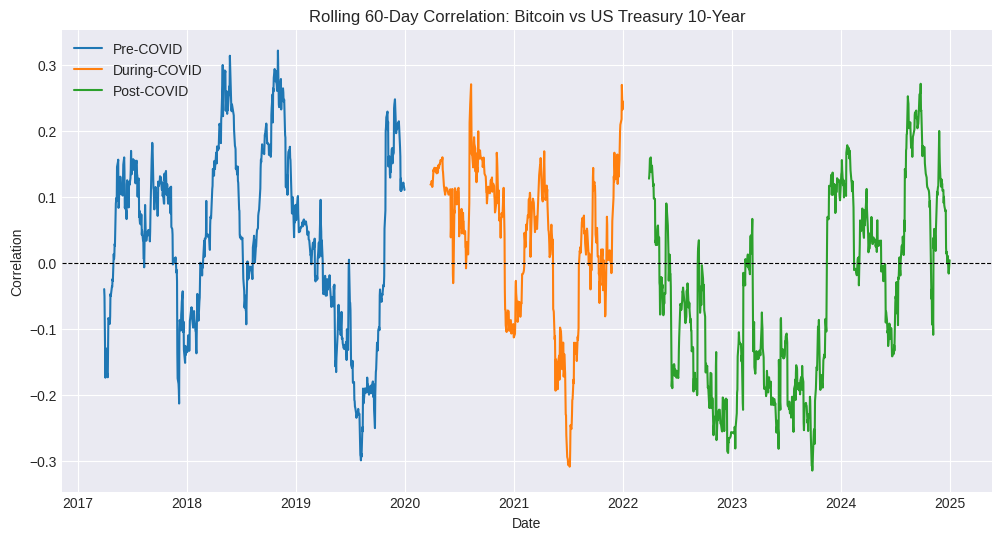

In [ ]:
import matplotlib.pyplot as plt

# Define rolling window size
ROLLING_WINDOW = 60

# Get asset names (excluding 'Period' column)
assets = returns.columns[:-1]

# Loop through all unique asset pairs
for i in range(len(assets)):
    for j in range(i + 1, len(assets)):  # Avoid self-correlations
        asset1 = assets[i]
        asset2 = assets[j]

        plt.figure(figsize=(12, 6))

        for period in returns["Period"].unique():
            # Filter returns for the given period
            subset = returns[returns["Period"] == period]

            # Compute rolling correlation for the asset pair
            rolling_corr = subset[asset1].rolling(ROLLING_WINDOW).corr(subset[asset2])

            # Plot rolling correlation over time
            plt.plot(subset.index, rolling_corr, label=period)

        # Plot settings
        plt.title(f"Rolling {ROLLING_WINDOW}-Day Correlation: {asset1} vs {asset2}")
        plt.xlabel("Date")
        plt.ylabel("Correlation")
        plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # Reference line at 0
        plt.legend()
        plt.show()

**Remarks:**

We observe from the above plots that for the majority of the assets’ correlations were more stable during the pre-pandemic period. The pattern changes during the pandemic period whereby correlations experience extreme fluctuations. During the post-pandemic period, we see that mostly the correlations fluctuations have stabilized, but more erratic than during the pre-pandemic period.

Highlighting specific asset pairs, we note that bitcoin and Equities had an increased correlation over time. The correlations were lower before the pandemic, surged during the pandemic and has been maintained at high-to-moderate positive levels. The relationship between US treasury yield and gold has been maintained as negative. This was heightened prior to pandemic, weakened during the pandemic but persisted after the pandemic. Furthermore, we observe a persistent positive relationship between crude oil and treasury yield with this trend spiking during the pandemic.


#### (c). Perform Hierarchical Clustering on Cross-Asset Correlations

We will be performing hierarchical clustering with an aim of identifying asset groups behaving similarly on the basis of their correlations. We begin by computing the correlation matrix, which is then converted into a distance matrix. Hierarchical clustering with appropriate linkage method is is then applied and the clusters visualized using dendrograms. We analyze the assets correlations behavior for the three periods.

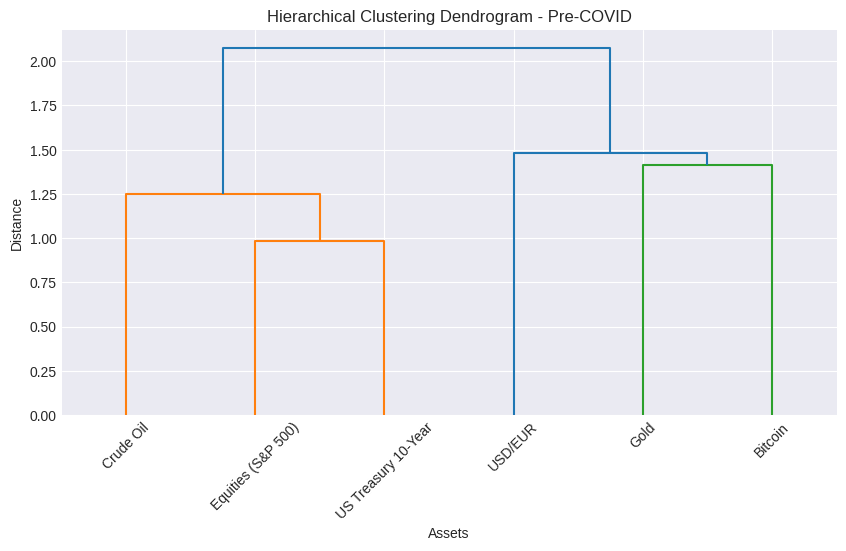

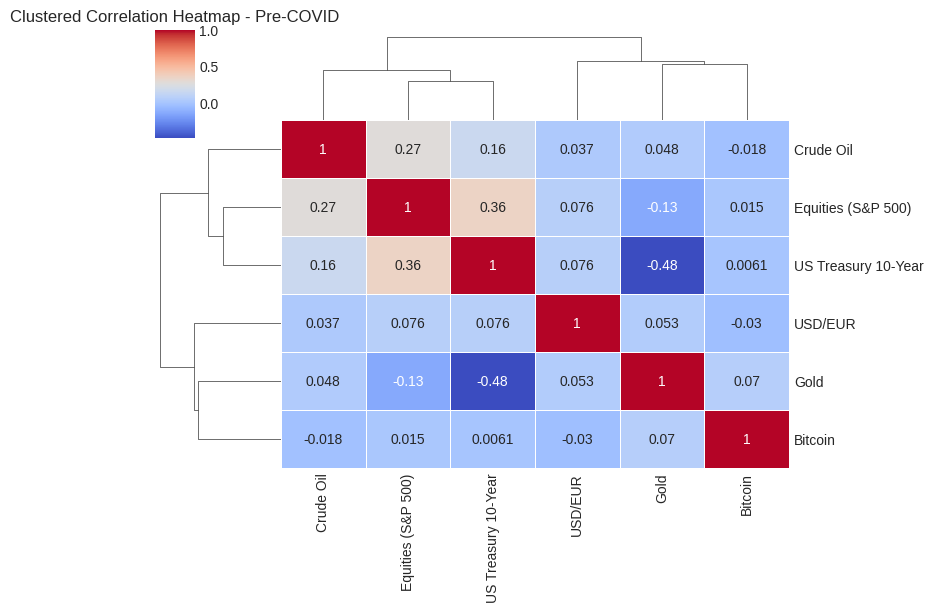

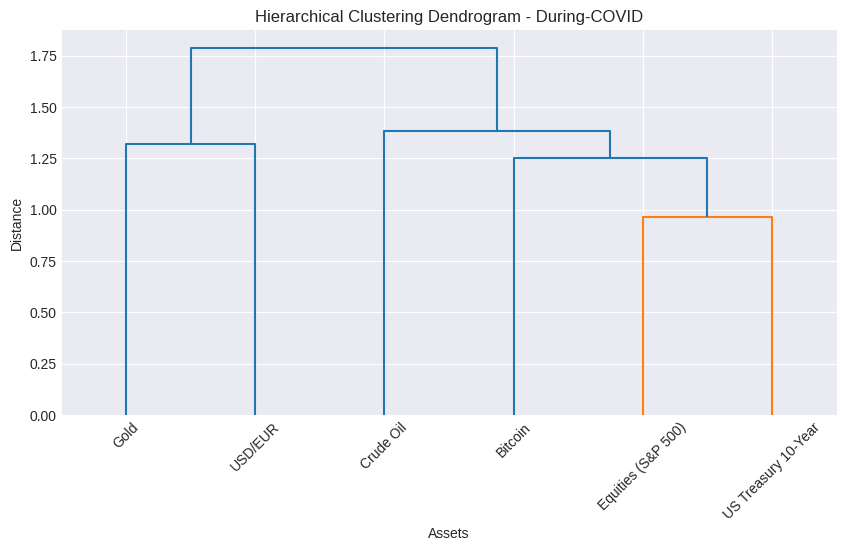

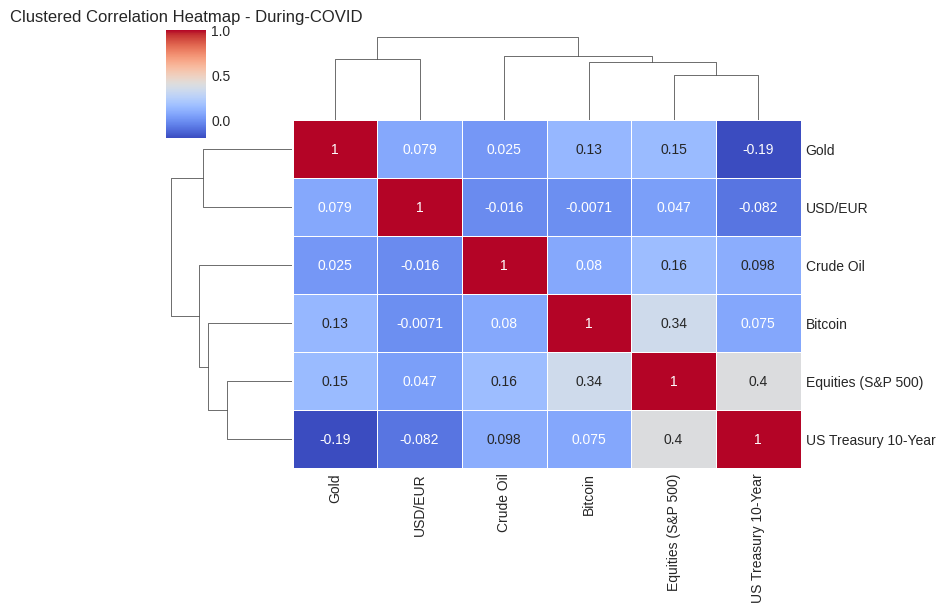

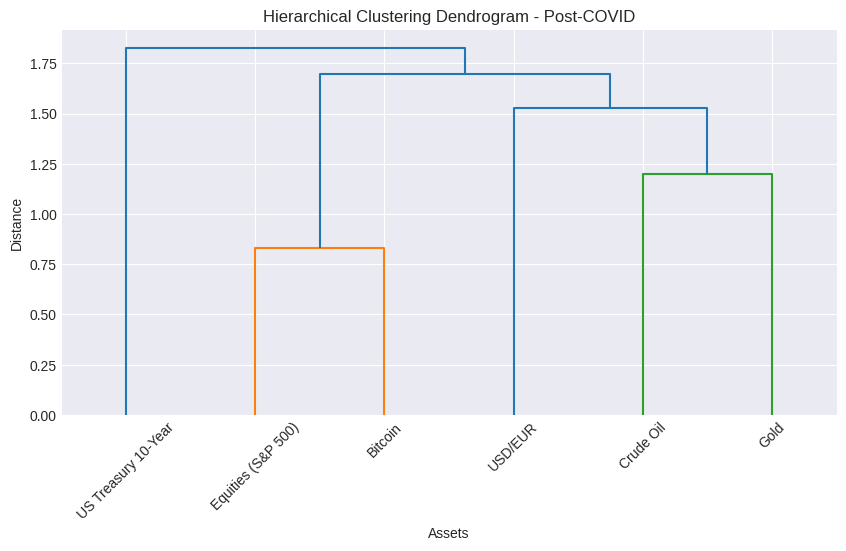

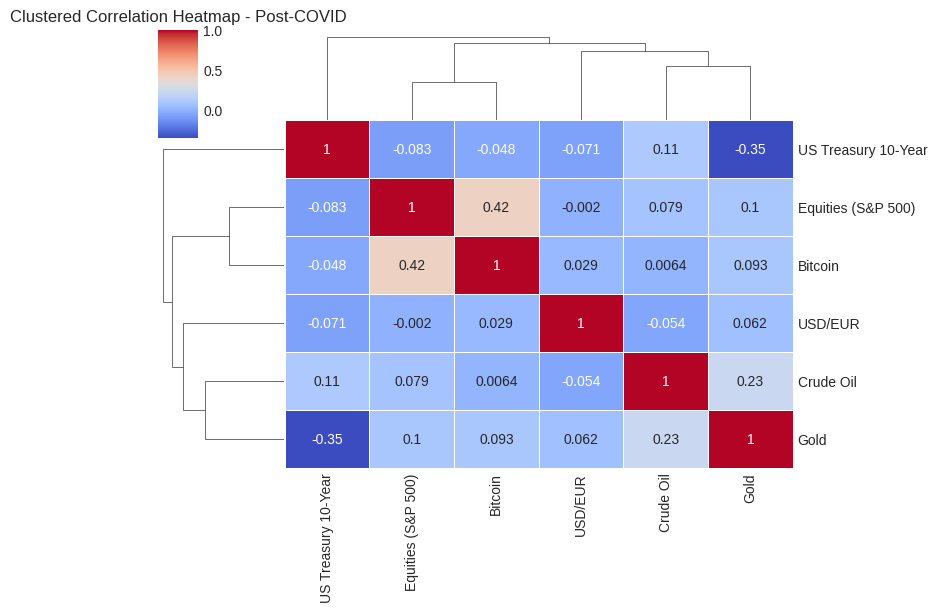

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Function to perform hierarchical clustering on the correlation matrix
def hierarchical_clustering(corr_matrix, title):
    # 1 Convert correlation to distance metric (1 - correlation)
    distance_matrix = 1 - corr_matrix

    # 2️ Perform hierarchical clustering using Ward's linkage
    linkage = sch.linkage(distance_matrix, method='ward')

    # 3️ Plot the dendrogram
    plt.figure(figsize=(10, 5))
    sch.dendrogram(linkage, labels=corr_matrix.columns, leaf_rotation=45, leaf_font_size=10)
    plt.title(f"Hierarchical Clustering Dendrogram - {title}")
    plt.xlabel("Assets")
    plt.ylabel("Distance")
    plt.show()

    # 4️ Plot the clustered heatmap
    sns.clustermap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, method="ward", figsize=(8, 6))
    plt.title(f"Clustered Correlation Heatmap - {title}")
    plt.show()

# 5️ Apply clustering for each period
for period in returns["Period"].unique():
    corr_matrix = returns[returns["Period"] == period].drop(columns=["Period"]).corr()
    hierarchical_clustering(corr_matrix, period)


**Remarks:**

**Pre-COVID Period.**

A strong cluster is observed consisting of crude oil and Equities assets. Additionally, US Treasury yield indicates slight correlation with this group, however this is seen at a higher hierarchy level. The USD/EUR Exchange rate forms its own cluster, due to its less correlation with the rest of the assets. Another distinct cluster formed is for gold and bitcoin assets which may suggest their similar behavior in the pre-pandemic period.

**During-COVID Period.**

Gold and USD/EUR became closely correlated during this period forming a cluster. We also see that crude oil and Bitcoin formed a cluster, possibly due go their high volatilities during this period. Interestingly, we note clustering of S&P 500 and US Treasury yield.

**Post-COVID Period.**

A new assets cluster was formed, consisting of gold and crude oil due to the high correlation between them. Also, Bitcoin and S&P 500 form another cluster with an improved correlation between them. The Bitcoin and S&P 500 assets cluster has been joined by USD/EUR, possibly due to their weaker relationship to crude oil. US Treasury 10-year distinguishes itself in its own cluster.

Highlighting the major cluster relationship shifts across the three periods, we see that during the pandemic, gold clustered with USD/EUR but clustered with crude oil in the post-pandemic period. For Bitcoin, it clustered with crude oil during the pandemic, evolving to form a cluster of high volatility assets. This changed after the pandemic period, where bitcoin formed cluster with S&P 500. We also note that US Treasury yield diverged from its cluster with S&P 500 during the pandemic to distinctly have its own cluster during post-pandemic period.


#### (d). Quantifying the Impact of Correlation Breakpoints on Portfolio Risk

We can assess now assess how cross-asset correlation changes affect portfolio risk across the three periods. This will be accompanied by first computing portfolio variance before and after the correlation shifts, measure volatility and then compare the portfolio risk across the periods.

**Step 1: Compute Portfolio Variance Over Time**

We assume equal-weighted allocation across all assets to simplify risk assessment.

In [ ]:
import numpy as np
import pandas as pd

# Define rolling window size for risk analysis
ROLLING_WINDOW = 60

# Compute rolling correlation matrix
rolling_corr_matrix = returns.drop(columns=["Period"]).rolling(ROLLING_WINDOW).corr()

# Compute rolling standard deviations (volatility)
rolling_volatility = returns.drop(columns=["Period"]).rolling(ROLLING_WINDOW).std()

# Define equal weights for portfolio (assuming equal allocation)
num_assets = len(returns.columns) - 1  # Excluding 'Period'
weights = np.ones(num_assets) / num_assets  # Equal allocation

# Function to compute portfolio variance at each time step
def compute_portfolio_variance(rolling_corr_matrix, rolling_volatility, weights):
    rolling_portfolio_variance = []
    dates = rolling_volatility.index[ROLLING_WINDOW - 1:]

    for date in dates:
        # Extract correlation matrix & volatility vector at time 'date'
        corr_matrix = rolling_corr_matrix.loc[date].values.reshape(num_assets, num_assets)
        vol_vector = rolling_volatility.loc[date].values.reshape(-1, 1)

        # Compute covariance matrix
        cov_matrix = np.dot(np.dot(vol_vector, vol_vector.T), corr_matrix)

        # Compute portfolio variance
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        rolling_portfolio_variance.append(portfolio_variance)

    return pd.DataFrame(rolling_portfolio_variance, index=dates, columns=["Portfolio Variance"])

# Compute rolling portfolio variance
portfolio_risk = compute_portfolio_variance(rolling_corr_matrix, rolling_volatility, weights)


**Step 2: Visualizing Portfolio Risk Changes Over Time**

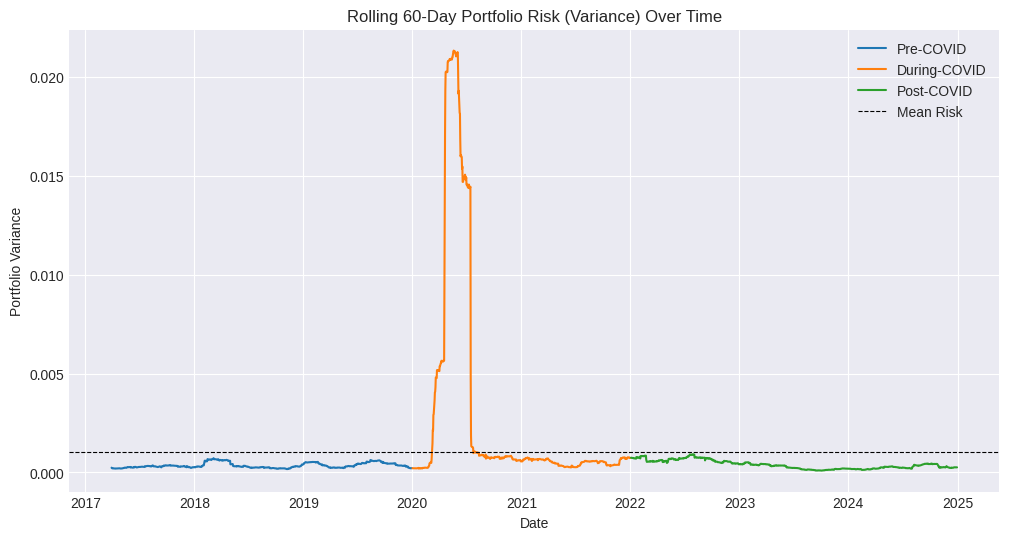

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period in returns["Period"].unique():
    subset = portfolio_risk[portfolio_risk.index.isin(returns[returns["Period"] == period].index)]
    plt.plot(subset.index, subset["Portfolio Variance"], label=period)

plt.title(f"Rolling {ROLLING_WINDOW}-Day Portfolio Risk (Variance) Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Variance")
plt.axhline(y=portfolio_risk["Portfolio Variance"].mean(), color="black", linestyle="--", linewidth=0.8, label="Mean Risk")
plt.legend()
plt.show()


**Remarks:**

The above plot of portfolio variance indicates low and stable levels prior to the pandemic period. During this period, we do not see significant fluctuation in volatility spikes, implying that the financial market was running smoothly.

During the pandemic, in the early 2020, we observe a sharp spike in portfolio risk with a variance exceeding 0.02. this represents a period of High uncertainty and increased correlations among assets. Nevertheless, we see that after the peak the portfolio risk gradually declined though it remained at a higher level compared to the pre-pandemic period.

After the pandemic, the portfolio risk has declined though it has not reverted to the pre-pandemic level. This suggests that there are structural shifts in the portfolio risk. We also observe that mostly, the portfolio risk goes below the mean risk (black dotted line).


## 5. Hypothesis Testing

In this section, we will be conducting hypothesis tests to test for statistical significance of the observed differences from the outcomes of the previous analysis. An ANOVA test will be done for the returns across periods, while Levene’s Test will be used in the case of Volatility differences. To test for significance of observed differences in correlations, we will use Fisher’s Z-Test.

### Significance Test for Asset Returns

Our dataset has daily returns for a number of assets, and a categorical variable of the three periods. Therefore, a one-way ANOVA will be use to confirm if the differences in mean returns across the three periods are significant. A one-way ANOVA will then be run for individual assets. If we find that the mean returns differ significantly for at least one of the periods from the ANOVA test, we will be conducting post-hoc Tukey Test to identify the periods that differ significantly.

We formulate the hypothesis as follows:

- The null hypothesis (H₀): The mean returns across the three periods are equal.
- The alternative hypothesis (H₁): At least one period has a significantly different mean return.

We will reject the null hypothesis if p-value < 0.05, which will mean that the mean returns across the three periods are the same. We fail to reject the null hypothesis if p-value >= 0.05, suggesting that at least one period has a mean return that differs from the others.

In [ ]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1. Perform ANOVA for each asset
anova_results = {}

# Use patsy's Q function to correctly handle column names with spaces and parentheses
for asset in returns.columns[:-1]:  # Exclude 'Period' column
    # Safely enclose the column name in the formula using patsy's Q function
    model = ols(f"Q('{asset}') ~ C(Period)", data=returns).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # Type-II ANOVA
    anova_results[asset] = anova_table

# Print ANOVA results
for asset, table in anova_results.items():
    print(f"\nANOVA Results for {asset}:\n", table)

# 2. Post-hoc Tukey Test
# for asset in returns.columns[:-1]:  # Exclude 'Period' column
    # tukey = pairwise_tukeyhsd(returns[asset], returns["Period"])
    # print(f"\nTukey's HSD Test for {asset}:\n", tukey)


ANOVA Results for Equities (S&P 500):
              sum_sq      df         F    PR(>F)
C(Period)  0.000096     2.0  0.349304  0.705222
Residual   0.275987  2003.0       NaN       NaN

ANOVA Results for Crude Oil:
               sum_sq      df         F   PR(>F)
C(Period)   0.014860     2.0  1.173647  0.30945
Residual   12.680445  2003.0       NaN      NaN

ANOVA Results for Gold:
              sum_sq      df         F    PR(>F)
C(Period)  0.000007     2.0  0.039215  0.961545
Residual   0.166821  2003.0       NaN       NaN

ANOVA Results for USD/EUR:
              sum_sq      df        F    PR(>F)
C(Period)  0.000015     2.0  0.36071  0.697226
Residual   0.041493  2003.0      NaN       NaN

ANOVA Results for Bitcoin:
              sum_sq      df         F    PR(>F)
C(Period)  0.003743     2.0  0.931815  0.394009
Residual   4.023453  2003.0       NaN       NaN

ANOVA Results for US Treasury 10-Year:
              sum_sq      df         F    PR(>F)
C(Period)  0.001338     2.0  0.621312  

**Remarks:**

The above represents the results of the ANOVA test for significance in mean return differences for each of our asset class. We note that for all the six assets, the p-values calculated are more than the significance level of 5%. Consequently, we will fail to reject the null hypothesis and conclude that there was no significant difference in the mean returns across the three periods. This implies that while the short term returns were highly volatile, especially in the pandemic period, in the long term the mean returns of individual assets were not impacted significantly. In this case, we will not be proceeding with post-hoc Tukey's Test of significance.

### Significance Test for Volatility Differences

To test for differences in volatility across the three periods, we will use Levene’s Test. We choose this test since it checks for homogeneity of variance and does not make normality assumption. This is critical since financial data mostly has a non-normal distribution with fat tails.

Let's first formulate our Hypothesis below:

- Null hypothesis (H₀): Volatility is equal across the three periods.
- Alternative hypothesis (H₁): At least one period has significantly different volatility.

When the p-value < 0.05, we reject H₀, meaning volatility differs significantly across the periods. If p-value ≥ 0.05, we fail to reject H₀, meaning there is no significant difference in volatility.


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# 1️ Compute rolling volatility (standard deviation) per period
volatility_data = returns.groupby("Period").std()

# 2️ Extract volatility values for each period
pre_covid_vol = returns[returns["Period"] == "Pre-COVID"].drop(columns=["Period"]).std()
during_covid_vol = returns[returns["Period"] == "During-COVID"].drop(columns=["Period"]).std()
post_covid_vol = returns[returns["Period"] == "Post-COVID"].drop(columns=["Period"]).std()

# 3️ Perform Levene's Test for each asset
levene_results = {}

for asset in returns.columns[:-1]:  # Exclude 'Period' column
    stat, p_value = stats.levene(
        returns[returns["Period"] == "Pre-COVID"][asset],
        returns[returns["Period"] == "During-COVID"][asset],
        returns[returns["Period"] == "Post-COVID"][asset]
    )
    levene_results[asset] = (stat, p_value)

# 4️ Print results
for asset, (stat, p_value) in levene_results.items():
    print(f"\nLevene’s Test for {asset}:")
    print(f"Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("🔴 Volatility is significantly different across periods.")
    else:
        print("🟢 No significant difference in volatility across periods.")


Levene’s Test for Equities (S&P 500):
Test Statistic: 41.0854, p-value: 0.0000
🔴 Volatility is significantly different across periods.

Levene’s Test for Crude Oil:
Test Statistic: 9.7853, p-value: 0.0001
🔴 Volatility is significantly different across periods.

Levene’s Test for Gold:
Test Statistic: 34.3243, p-value: 0.0000
🔴 Volatility is significantly different across periods.

Levene’s Test for USD/EUR:
Test Statistic: 9.1807, p-value: 0.0001
🔴 Volatility is significantly different across periods.

Levene’s Test for Bitcoin:
Test Statistic: 18.4820, p-value: 0.0000
🔴 Volatility is significantly different across periods.

Levene’s Test for US Treasury 10-Year:
Test Statistic: 132.4173, p-value: 0.0000
🔴 Volatility is significantly different across periods.


**Remarks:**

The results of the test indicate that for each asset, the volatilities across the three periods were significantly different. This is in contrast with the significance test for difference in mean returns earlier performed, implying that while mean returns remain stable, the price fluctuations and market volatility differ significantly across the three periods.

### Significance Test for Cross-Asset Correlation

To test for the statistical significance in the differences between the asset correlations across the periods, we use the Fisher’s Z-test. This test works with non-normal data by converting into normally distributed z-scores. This makes it suitable for this case due to the nature of non-gaussian financial data.

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd

def fisher_z_test(r1, r2, n1, n2):
    """Performs Fisher's Z-test to compare two correlation coefficients."""
    # Apply Fisher Z-transformation
    Z1 = 0.5 * np.log((1 + r1) / (1 - r1))
    Z2 = 0.5 * np.log((1 + r2) / (1 - r2))

    # Compute standard error
    SE1 = 1 / np.sqrt(n1 - 3)
    SE2 = 1 / np.sqrt(n2 - 3)

    # Compute Z-statistic
    Z_stat = (Z1 - Z2) / np.sqrt(SE1**2 + SE2**2)

    # Compute p-value (two-tailed test)
    p_value = 2 * (1 - stats.norm.cdf(abs(Z_stat)))

    return Z_stat, p_value

# Get unique periods
periods = ["Pre-COVID", "During-COVID", "Post-COVID"]

# Prepare to store results
correlation_differences = []

# Compute correlation matrices for each period
corr_matrices = {period: returns[returns["Period"] == period].iloc[:, :-1].corr() for period in periods}
sample_sizes = {period: len(returns[returns["Period"] == period]) for period in periods}  # Sample sizes

# Compare correlations across periods
for asset1 in returns.columns[:-1]:
    for asset2 in returns.columns[:-1]:
        if asset1 != asset2:  # Avoid self-correlation

            # Fetch correlation coefficients and sample sizes
            r_pre, r_during, r_post = corr_matrices["Pre-COVID"].loc[asset1, asset2], \
                                      corr_matrices["During-COVID"].loc[asset1, asset2], \
                                      corr_matrices["Post-COVID"].loc[asset1, asset2]
            n_pre, n_during, n_post = sample_sizes["Pre-COVID"], sample_sizes["During-COVID"], sample_sizes["Post-COVID"]

            # Fisher Z-tests
            Z_pre_during, p_pre_during = fisher_z_test(r_pre, r_during, n_pre, n_during)
            Z_during_post, p_during_post = fisher_z_test(r_during, r_post, n_during, n_post)
            Z_pre_post, p_pre_post = fisher_z_test(r_pre, r_post, n_pre, n_post)

            # Store results
            correlation_differences.append([asset1, asset2, "Pre vs During", Z_pre_during, p_pre_during])
            correlation_differences.append([asset1, asset2, "During vs Post", Z_during_post, p_during_post])
            correlation_differences.append([asset1, asset2, "Pre vs Post", Z_pre_post, p_pre_post])

# Convert results to DataFrame
df_results = pd.DataFrame(correlation_differences, columns=["Asset 1", "Asset 2", "Period Comparison", "Z-Statistic", "p-Value"])

# Display only significant differences (p < 0.05)
df_results[df_results["p-Value"] < 0.05]

Asset 1              Asset 2 Period Comparison  Z-Statistic  \
0    Equities (S&P 500)            Crude Oil     Pre vs During     2.089583   
2    Equities (S&P 500)            Crude Oil       Pre vs Post     3.918039   
3    Equities (S&P 500)                 Gold     Pre vs During    -4.887957   
5    Equities (S&P 500)                 Gold       Pre vs Post    -4.467678   
9    Equities (S&P 500)              Bitcoin     Pre vs During    -5.859841   
11   Equities (S&P 500)              Bitcoin       Pre vs Post    -8.266625   
13   Equities (S&P 500)  US Treasury 10-Year    During vs Post     8.752476   
14   Equities (S&P 500)  US Treasury 10-Year       Pre vs Post     8.808574   
15            Crude Oil   Equities (S&P 500)     Pre vs During     2.089583   
17            Crude Oil   Equities (S&P 500)       Pre vs Post     3.918039   
19            Crude Oil                 Gold    During vs Post    -3.563335   
20            Crude Oil                 Gold       Pre vs Post    -3.521797   
30                 Gold   Equities (S&P 500)     Pre vs During    -4.887957   
32                 Gold   Equities (S&P 500)       Pre vs Post    -4.467678   
34                 Gold            Crude Oil    During vs Post    -3.563335   
35                 Gold            Crude Oil       Pre vs Post    -3.521797   
42                 Gold  US Treasury 10-Year     Pre vs During    -5.553099   
43                 Gold  US Treasury 10-Year    During vs Post     3.028011   
44                 Gold  US Treasury 10-Year       Pre vs Post    -2.820796   
57              USD/EUR  US Treasury 10-Year     Pre vs During     2.731337   
59              USD/EUR  US Treasury 10-Year       Pre vs Post     2.844688   
60              Bitcoin   Equities (S&P 500)     Pre vs During    -5.859841   
62              Bitcoin   Equities (S&P 500)       Pre vs Post    -8.266625   
73              Bitcoin  US Treasury 10-Year    During vs Post     2.134535   
76  US Treasury 10-Year   Equities (S&P 500)    During vs Post     8.752476   
77  US Treasury 10-Year   Equities (S&P 500)       Pre vs Post     8.808574   
81  US Treasury 10-Year                 Gold     Pre vs During    -5.553099   
82  US Treasury 10-Year                 Gold    During vs Post     3.028011   
83  US Treasury 10-Year                 Gold       Pre vs Post    -2.820796   
84  US Treasury 10-Year              USD/EUR     Pre vs During     2.731337   
86  US Treasury 10-Year              USD/EUR       Pre vs Post     2.844688   
88  US Treasury 10-Year              Bitcoin    During vs Post     2.134535   

         p-Value  
0   3.665530e-02  
2   8.927240e-05  
3   1.018880e-06  
5   7.907330e-06  
9   4.633112e-09  
11  2.220446e-16  
13  0.000000e+00  
14  0.000000e+00  
15  3.665530e-02  
17  8.927240e-05  
19  3.661735e-04  
20  4.286328e-04  
30  1.018880e-06  
32  7.907330e-06  
34  3.661735e-04  
35  4.286328e-04  
42  2.806496e-08  
43  2.461689e-03  
44  4.790468e-03  
57  6.307784e-03  
59  4.445488e-03  
60  4.633112e-09  
62  2.220446e-16  
73  3.279898e-02  
76  0.000000e+00  
77  0.000000e+00  
81  2.806496e-08  
82  2.461689e-03  
83  4.790468e-03  
84  6.307784e-03  
86  4.445488e-03  
88  3.279898e-02

The above output represents asset pairs, the periods under comparison,the Z-statistic and their corresponding p-values. We have displayed this information for the assets that had significant differences in their correlations across the three periods.

To gain further insight into the significance test results, we visualize the Z-statistic values in the following.

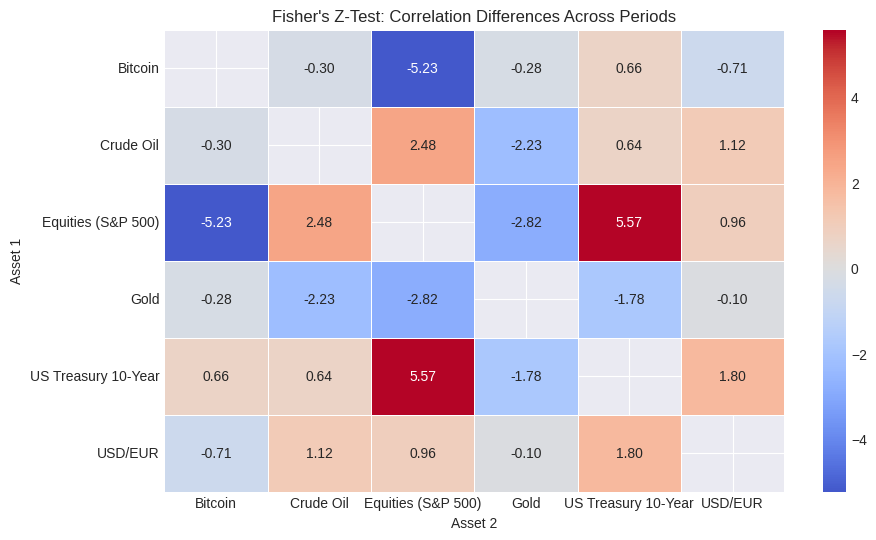

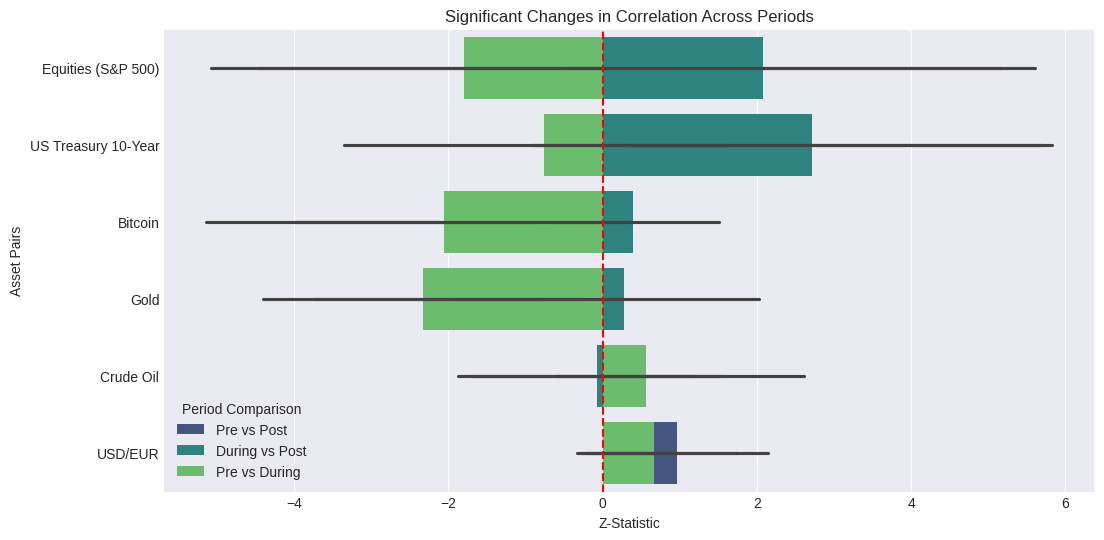

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert p-values to significance labels
df_results["Significance"] = df_results["p-Value"].apply(lambda x: "***" if x < 0.001 else
                                                          "**" if x < 0.01 else
                                                          "*" if x < 0.05 else "")

# Pivot Data for Heatmap (reshaping)
# heatmap_data = df_results.pivot(index="Asset 1", columns="Asset 2", values="Z-Statistic")

# Pivot Data for Heatmap (reshaping), ensuring unique index/column pairs
heatmap_data = df_results.pivot_table(  # Use pivot_table with an aggregation function
    index="Asset 1",
    columns="Asset 2",
    values="Z-Statistic",
    aggfunc='mean'  # or another appropriate aggregation like 'first', 'sum', etc.
)

# 1. Heatmap of Z-Statistics**
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, center=0)
plt.title("Fisher's Z-Test: Correlation Differences Across Periods")
plt.xlabel("Asset 2")
plt.ylabel("Asset 1")
plt.show()

# 2. Bar Chart of Significant Z-Statistics**
df_sorted = df_results.sort_values("Z-Statistic", key=abs, ascending=False)  # Sort by magnitude
plt.figure(figsize=(12, 6))
sns.barplot(x="Z-Statistic", y="Asset 1", hue="Period Comparison", data=df_sorted, dodge=False, palette="viridis")
plt.axvline(x=0, color="red", linestyle="dashed")  # Reference line at 0
plt.title("Significant Changes in Correlation Across Periods")
plt.xlabel("Z-Statistic")
plt.ylabel("Asset Pairs")
plt.legend(title="Period Comparison")
plt.show()


**Remarks:**

The heatmap visualized above represents the Fisher’s Z-test results where the type and intensity of the color informs on the direction and magnitude of the correlation differences. The red cells indicate strong positive differences i.e. highly significant changes in correlations while blue cells indicate strong negative differences.

We observe Equities (S&P 500) and Bitcoin experienced a strong negative change (-5.23) implying that their correlations dropped significantly across the periods. Also, there is a strong positive shift in the correlations of US Treasury 10-year and Equities (S&P 500) (5.57). Crude oil and gold show moderate negative shift at -2.23.

The bar chart displays the significant correlation changes across the different periods for specific assets. The Z-statistic value is plotted on the x-axis measuring the extent of the change in correlation. The bars extending to the left represents negative changes while those to the right represent positive changes. The different periods (Pre vs. During, Pre vs. Post, During vs. Post) are represented by the different bar colors. The dashed red line at 0 indicates no change in correlation while the bars further from this line indicate stronger correlation shifts.

We observe on the bar chart that equities (S&P 500) versus US Treasury 10-year shows increased correlation during both during and after the pandemic periods. On the other hand, we observe that gold versus Equities (S&P 500) and Bitcoin versus Equities have significant negative shifts implying decreased correlations between these assets across the periods. Furthermore, we note that the strongest changes have occurred between pre- versus post-pandemic periods.


## 5. Model Fitting

Our objective here is to use ARIMA and GARCH models to perform predictive modeling and assess volatility. We begin by testing for stationarity of the time series data using ADF test, then fit the models, perform forecasts and compare results.

### Step 1: Test for Stationarity Using the ADF Test

We will use ADF test to check if the assets’ time series have constant mean and variances (stationary) across the periods. The hypotheses are as stated below:
- Null Hypothesis (H₀): The time series is non-stationary (has a unit root).
- Alternative Hypothesis (H₁): The time series is stationary.

We reject the null hypothesis if p-value < 0.05, implying that the series is stationary. If p-value ≥ 0.05, we fail to reject H₀ which suggests that the series is non-stationary and it may need differencing.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series, asset_name):
    result = adfuller(series.dropna())  # Drop NaNs before testing
    print(f"\nADF Test for {asset_name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    if result[1] < 0.05:
        print("✅ The series is stationary (reject H₀).")
    else:
        print("❌ The series is non-stationary (fail to reject H₀). Consider differencing.")

# Perform ADF test on returns for each asset
for asset in returns.columns[:-1]:  # Exclude 'Period' column
    adf_test(returns[asset], asset)



ADF Test for Equities (S&P 500):
ADF Statistic: -13.8036
p-value: 0.0000
Critical Values:
   1%: -3.4336
   5%: -2.8630
   10%: -2.5675
✅ The series is stationary (reject H₀).

ADF Test for Crude Oil:
ADF Statistic: -10.2927
p-value: 0.0000
Critical Values:
   1%: -3.4337
   5%: -2.8630
   10%: -2.5675
✅ The series is stationary (reject H₀).

ADF Test for Gold:
ADF Statistic: -19.9691
p-value: 0.0000
Critical Values:
   1%: -3.4336
   5%: -2.8630
   10%: -2.5675
✅ The series is stationary (reject H₀).

ADF Test for USD/EUR:
ADF Statistic: -44.5842
p-value: 0.0000
Critical Values:
   1%: -3.4336
   5%: -2.8630
   10%: -2.5675
✅ The series is stationary (reject H₀).

ADF Test for Bitcoin:
ADF Statistic: -15.4889
p-value: 0.0000
Critical Values:
   1%: -3.4336
   5%: -2.8630
   10%: -2.5675
✅ The series is stationary (reject H₀).

ADF Test for US Treasury 10-Year:
ADF Statistic: -8.1214
p-value: 0.0000
Critical Values:
   1%: -3.4337
   5%: -2.8630
   10%: -2.5675
✅ The series is station

We note that at significance level of 5%, we reject the null hypothesis for all the assets. This suggests that the assets’ it time series do not have unit roots; hence they are stationary. Since this is the case, we will not need to do series differencing. A stationary time series has a constant mean and variance over time.

### Step 2: Fit an ARIMA Model for Return Forecasting

Here, we fit ARIMA model to each of the assets’ time series data to determine the best parameters and Perform returns forecasting.

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.0 MB/s eta 0:00:00



Fitting ARIMA model for Equities (S&P 500)...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-12187.769, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-12136.083, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-12182.782, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-12175.543, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-12188.803, Time=4.36 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-12191.985, Time=5.27 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-12192.395, Time=3.34 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-12190.073, Time=3.94 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-12193.276, Time=4.34 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-12191.521, Time=9.73 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=-12191.819, Time=7.88 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=-12245.532, Time=3.62 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=-12249.088, Time=2.91 sec
 ARIMA(2,0,4)(0,0,0)[0]   

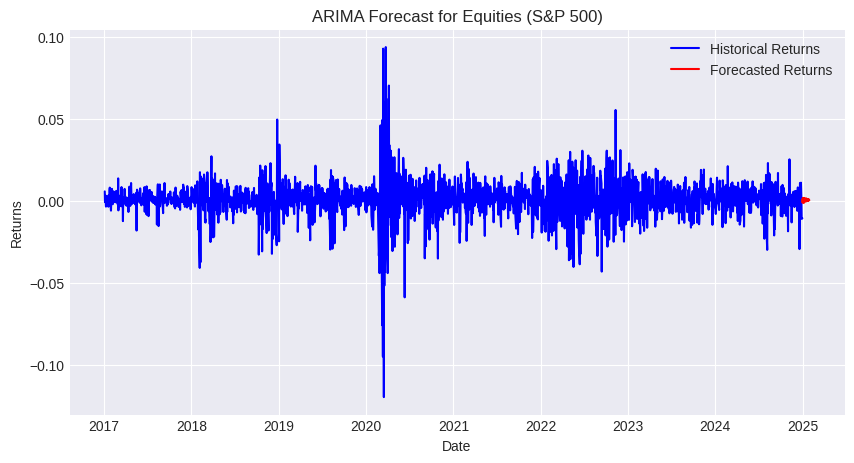


Fitting ARIMA model for Crude Oil...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4728.139, Time=1.73 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4460.408, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4638.972, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4712.956, Time=0.59 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4721.556, Time=1.84 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4729.425, Time=0.57 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4716.420, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4728.295, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-4731.746, Time=1.24 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-4730.409, Time=0.38 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-4731.011, Time=1.55 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-4732.834, Time=1.90 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-4727.818, Time=1.63 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-4738.

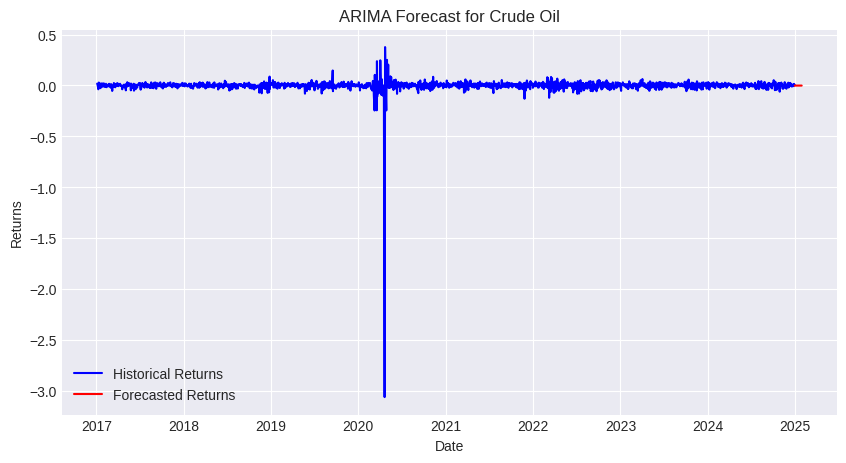


Fitting ARIMA model for Gold...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-13137.679, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-13146.198, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-13145.185, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-13145.186, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-13143.182, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-13148.970, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-13148.185, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-13148.192, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-13146.191, Time=1.51 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 3.747 seconds

Optimal ARIMA order for Gold: (0, 0, 0)


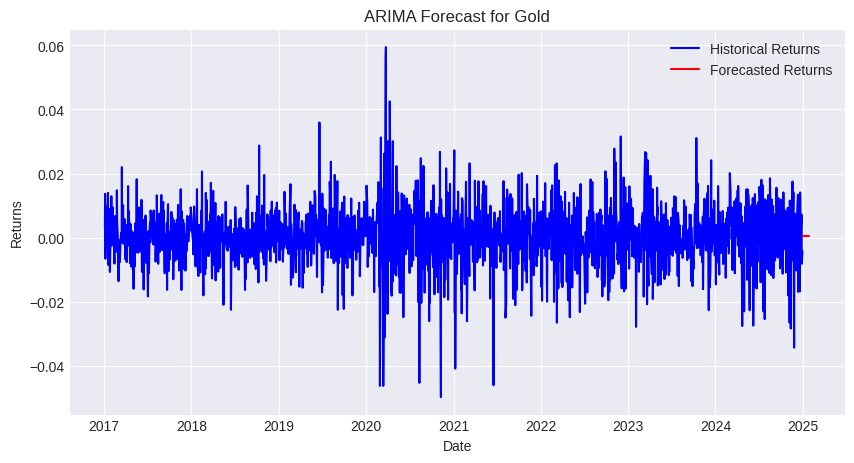


Fitting ARIMA model for USD/EUR...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-15936.558, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-15941.484, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-15939.516, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-15939.509, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-15937.494, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-15939.492, Time=0.50 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.723 seconds

Optimal ARIMA order for USD/EUR: (0, 0, 0)


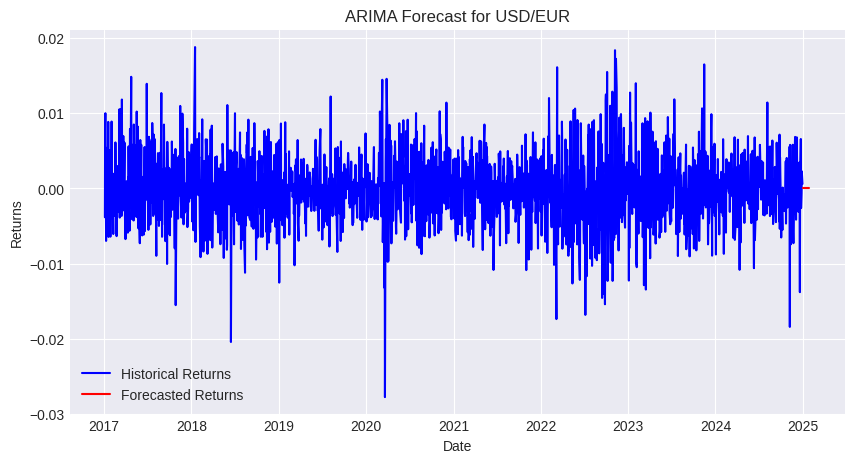


Fitting ARIMA model for Bitcoin...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-6756.711, Time=3.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6753.625, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6751.931, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6751.912, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6760.755, Time=1.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-6752.060, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6749.921, Time=0.28 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-6752.564, Time=0.54 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-6754.271, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6750.011, Time=0.50 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-6757.001, Time=1.78 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-6760.575, Time=1.38 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 10.035 seconds

Optimal ARIMA order for Bitcoin: (1, 0

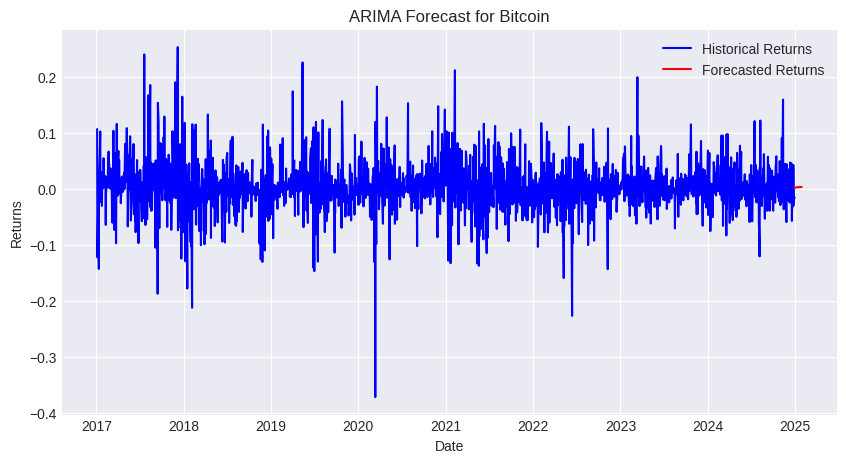


Fitting ARIMA model for US Treasury 10-Year...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-8072.066, Time=1.85 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-8014.232, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8012.608, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-8012.667, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-8035.739, Time=1.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-8035.628, Time=0.96 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-8032.338, Time=1.81 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-8094.443, Time=2.23 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-8033.938, Time=3.39 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-8086.635, Time=3.54 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-8097.229, Time=2.88 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-8056.099, Time=2.16 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-8104.043, Time=2.64 sec
 ARIMA(4,0,4)(0,0,0)[0]             : 

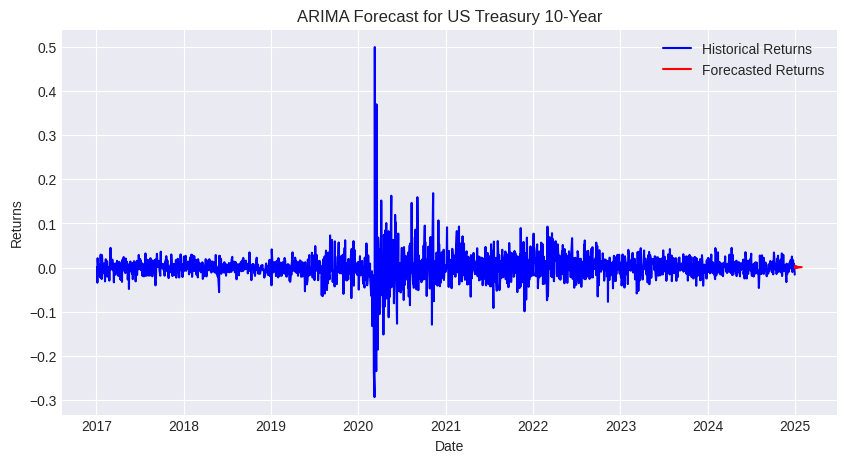

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima  # Helps with automatic parameter selection

# Function to fit ARIMA and forecast returns
def fit_arima(series, asset_name, forecast_days=30):
    series = series.dropna()  # Drop NaNs before modeling

    # 1️ Auto-select optimal ARIMA(p,d,q) parameters
    auto_model = auto_arima(series, seasonal=False, stepwise=True, trace=True)
    p, d, q = auto_model.order  # Extract best parameters

    print(f"\nOptimal ARIMA order for {asset_name}: ({p}, {d}, {q})")

    # 2️ Fit ARIMA model with selected parameters
    model = ARIMA(series, order=(p, d, q))
    model_fit = model.fit()

    # 3️ Forecast future returns
    forecast = model_fit.forecast(steps=forecast_days)

    # 4️ Plot historical returns + forecast
    plt.figure(figsize=(10, 5))
    plt.plot(series, label="Historical Returns", color="blue")
    plt.plot(pd.date_range(series.index[-1], periods=forecast_days, freq='D'),
             forecast, label="Forecasted Returns", color="red")
    plt.title(f"ARIMA Forecast for {asset_name}")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.show()

    return model_fit, forecast

# Fit ARIMA for each asset and forecast returns
arima_models = {}
forecasts = {}

for asset in returns.columns[:-1]:  # Exclude 'Period' column
    print(f"\nFitting ARIMA model for {asset}...")
    model_fit, forecast = fit_arima(returns[asset], asset)
    arima_models[asset] = model_fit
    forecasts[asset] = forecast


### Step 3: Test for Heteroskedasticity & Autocorrelation

To start, we check whether fitting a GARCH model is appropriate by checking the series’ heteroskedasticity and autocorrelation. We will check whether volatility clusters across the time periods using Ljung-Box test and Engle ARCH test to confirm if the variance is varying with time. If we find that p-value <= 0.05, then we conclude that volatility varies with time hence GARCH model use is appropriate.

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import acf, q_stat

# Function to test for heteroskedasticity (ARCH Effect) & autocorrelation
def check_garch_necessity(series, asset_name, lags=10):
    series = series.dropna()  # Drop NaNs before testing

    # 1️ Engle’s ARCH Test for heteroskedasticity
    arch_test = het_arch(series)
    arch_pvalue = arch_test[1]  # p-value of ARCH test

    # 2️ Ljung-Box Test for autocorrelation in squared returns
    squared_series = series ** 2
    lb_test = q_stat(acf(squared_series, nlags=lags, fft=False)[1:], len(squared_series))
    lb_pvalue = lb_test[1][-1]  # Get p-value from last lag

    print(f"\nGARCH Pre-Check for {asset_name}:")
    print(f"Engle’s ARCH Test p-value: {arch_pvalue:.4f} ({'✅ GARCH Needed' if arch_pvalue < 0.05 else '❌ No GARCH'})")
    print(f"Ljung-Box Test p-value: {lb_pvalue:.4f} ({'✅ GARCH Needed' if lb_pvalue < 0.05 else '❌ No GARCH'})")

    return arch_pvalue, lb_pvalue

# Apply tests to each asset
garch_pre_check = {}

for asset in returns.columns[:-1]:  # Exclude 'Period' column
    print(f"\nTesting {asset} for GARCH suitability...")
    arch_pval, lb_pval = check_garch_necessity(returns[asset], asset)
    garch_pre_check[asset] = {"ARCH p-value": arch_pval, "Ljung-Box p-value": lb_pval}


Testing Equities (S&P 500) for GARCH suitability...

GARCH Pre-Check for Equities (S&P 500):
Engle’s ARCH Test p-value: 0.0000 (✅ GARCH Needed)
Ljung-Box Test p-value: 0.0000 (✅ GARCH Needed)

Testing Crude Oil for GARCH suitability...

GARCH Pre-Check for Crude Oil:
Engle’s ARCH Test p-value: 0.0000 (✅ GARCH Needed)
Ljung-Box Test p-value: 0.0000 (✅ GARCH Needed)

Testing Gold for GARCH suitability...

GARCH Pre-Check for Gold:
Engle’s ARCH Test p-value: 0.0000 (✅ GARCH Needed)
Ljung-Box Test p-value: 0.0000 (✅ GARCH Needed)

Testing USD/EUR for GARCH suitability...

GARCH Pre-Check for USD/EUR:
Engle’s ARCH Test p-value: 0.0000 (✅ GARCH Needed)
Ljung-Box Test p-value: 0.0000 (✅ GARCH Needed)

Testing Bitcoin for GARCH suitability...

GARCH Pre-Check for Bitcoin:
Engle’s ARCH Test p-value: 0.0000 (✅ GARCH Needed)
Ljung-Box Test p-value: 0.0000 (✅ GARCH Needed)

Testing US Treasury 10-Year for GARCH suitability...

GARCH Pre-Check for US Treasury 10-Year:
Engle’s ARCH Test p-value: 0.

### Step 4: Fit a GARCH Model for Volatility Forecasting

We checked for stationarity in the prior step, now will proceed to calculate the rolling volatilities and fit a GARCH (1,1) model to forecast future volatilities. The results will then be visualized.


Fitting GARCH model for Equities (S&P 500)...


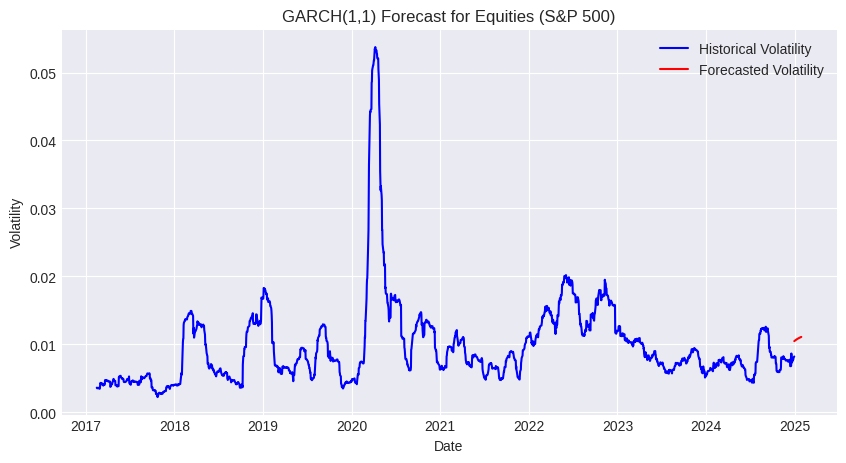


Fitting GARCH model for Crude Oil...


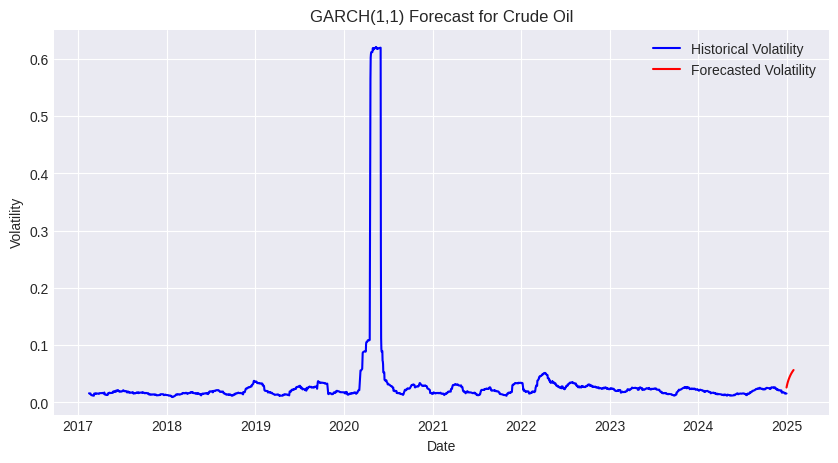


Fitting GARCH model for Gold...


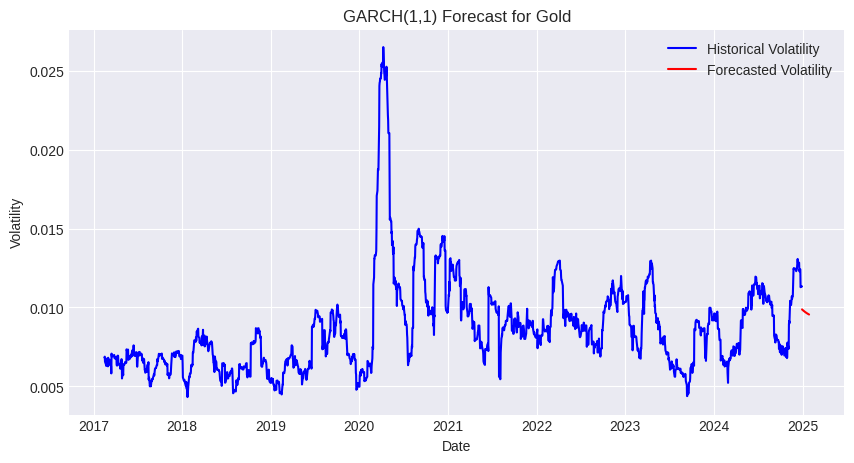


Fitting GARCH model for USD/EUR...


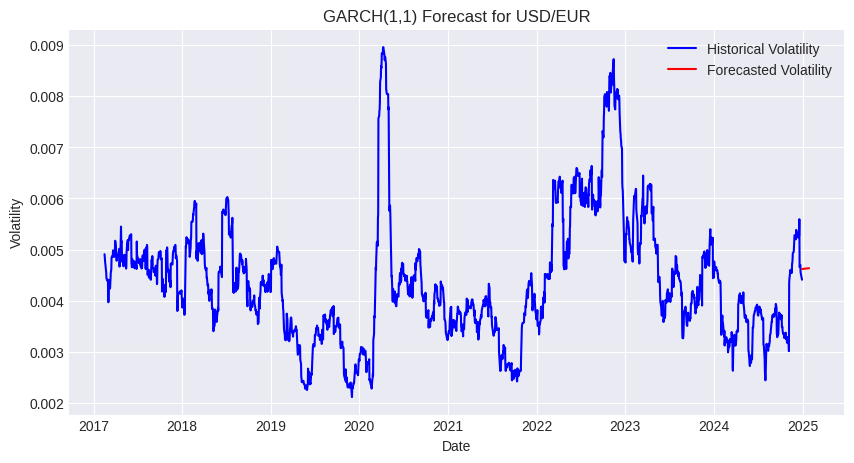


Fitting GARCH model for Bitcoin...


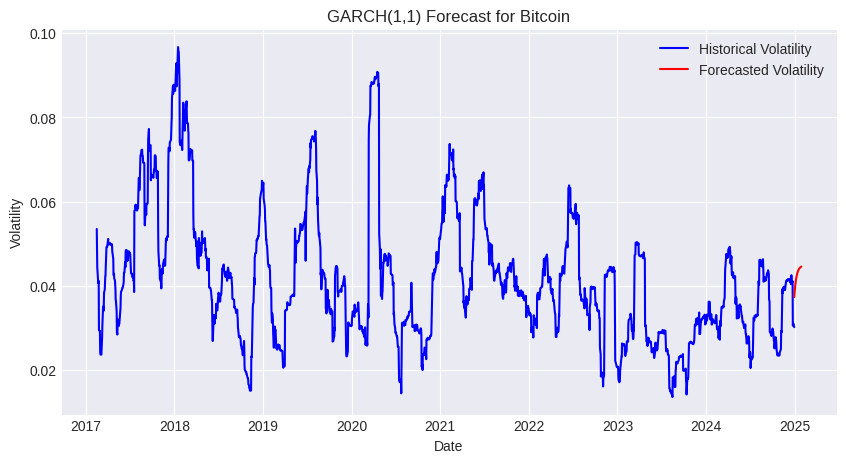


Fitting GARCH model for US Treasury 10-Year...


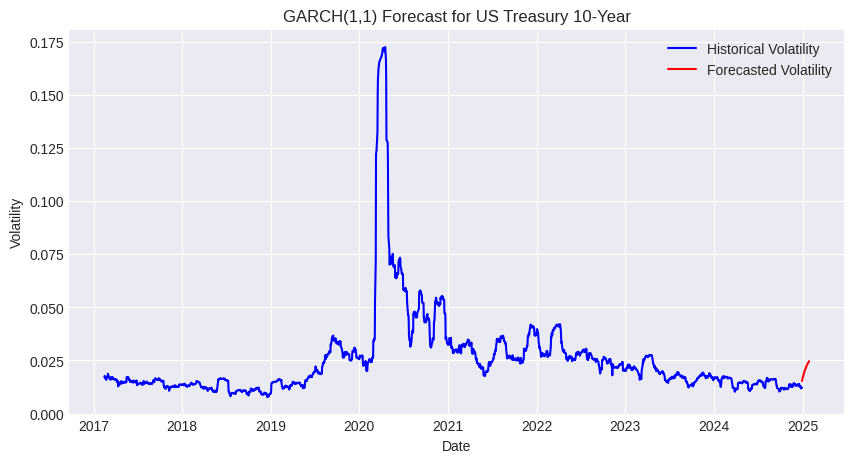

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model  # GARCH model from 'arch' package

# Function to fit GARCH model and forecast volatility
def fit_garch(series, asset_name, forecast_days=30):
    series = series.dropna()  # Drop NaNs before modeling

    # 1️ Fit GARCH(1,1) model
    model = arch_model(series, vol='Garch', p=1, q=1, mean='Zero', dist='normal')
    model_fit = model.fit(disp="off")  # Suppress output

    # 2️ Forecast future volatility
    forecast = model_fit.forecast(horizon=forecast_days, reindex=False)  # reindex=False to prevent potential indexing errors

    # Check if the forecast variance is empty
    if forecast.variance.empty:
        print(f"Warning: GARCH forecast variance is empty for {asset_name}. Skipping volatility forecast.")
        return model_fit, None  # Return None for volatility_forecast

    # *** Changed part ***
    # Get volatility forecast for all forecast days
    volatility_forecast = np.sqrt(forecast.variance.iloc[-1]).values


    # 3️ Plot historical and forecasted volatility
    plt.figure(figsize=(10, 5))
    plt.plot(series.rolling(30).std(), label="Historical Volatility", color="blue")  # Rolling volatility

    # Check if volatility_forecast is not None before plotting
    if volatility_forecast is not None:
        plt.plot(pd.date_range(series.index[-1], periods=forecast_days, freq='D'),
                 volatility_forecast, label="Forecasted Volatility", color="red")

    plt.title(f"GARCH(1,1) Forecast for {asset_name}")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()

    return model_fit, volatility_forecast

# Fit GARCH for each asset and forecast volatility
garch_models = {}
volatility_forecasts = {}

for asset in returns.columns[:-1]:  # Exclude 'Period' column
    print(f"\nFitting GARCH model for {asset}...")
    model_fit, volatility_forecast = fit_garch(returns[asset], asset)
    garch_models[asset] = model_fit
    volatility_forecasts[asset] = volatility_forecast

## 6. Strategy Development

Our objective in this section is to propose strategies and techniques that can enhance risk mitigation. We plan to come up with allocation strategies employing volatility and correlation. We will also evaluate the safe-haven assets during crises. Furthermore, we will develop stress-testing frameworks that will enable us to assess portfolio resilience during extreme market conditions.

### **Strategy 1: Dynamic Portfolio Rebalancing Using Volatility & Correlation**

We noted that assets with higher volatility and increasing correlations leads to increased risk. Therefore, our first strategy will be to adjust allocations dynamically depending on the historical and the forecasted volatility or volatility. This will be achieved by reducing exposure to assets showing high volatility and high correlation with other risky assets and increasing exposure to assets displaying minimal correlations and stable volatilities.

We will be implementing risk-based portfolio allocation using GRACH-forecasted volatility to adjust the allocations and using rolling correlations in identification of opportunities for diversification.

In [ ]:
import numpy as np
import pandas as pd

# Define allocation strategy based on inverse volatility
def inverse_volatility_allocation(volatility_df):
    """
    Allocates weights inversely proportional to asset volatility.
    """
    inv_vol = 1 / volatility_df  # Inverse of volatility
    weights = inv_vol.div(inv_vol.sum(axis=1), axis=0)  # Normalize weights
    return weights

# Compute dynamic weights based on forecasted volatility
dynamic_weights = inverse_volatility_allocation(pd.DataFrame(volatility_forecasts))

# Display the latest allocation recommendations
print("\nLatest Dynamic Portfolio Weights:")
print(dynamic_weights.tail())



Latest Dynamic Portfolio Weights:
    Equities (S&P 500)  Crude Oil      Gold   USD/EUR   Bitcoin  \
25            0.183529   0.037532  0.211217  0.437204  0.045589   
26            0.183505   0.037149  0.211701  0.437752  0.045599   
27            0.183475   0.036786  0.212168  0.438273  0.045611   
28            0.183440   0.036441  0.212621  0.438769  0.045626   
29            0.183400   0.036112  0.213059  0.439242  0.045642   

    US Treasury 10-Year  
25             0.084929  
26             0.084294  
27             0.083687  
28             0.083104  
29             0.082545  


### **Strategy 2: Evaluating Safe-Haven Assets During Crises**

Whenever the market experiences difficulties, investors resort to investing in assets considered as safe-haven investments. Traditionally, these include assets such as Gold and US Treasuries. We aim at evaluating if the assets, gold and US Treasury 10-year show weak correlations with risky assets (i.e. equities and bitcoin) during crises such as the pandemic. If strong correlations are observed instead, then they may not be suitable choice as safe-haven investment options.

To implement analysis of the safe-haven assets, we will first compare the correlation of Gold and US Treasury 10-year to S&P 500 & Bitcoin across the periods. We will also assess the volatility of the safe-haven assets i.e. gold and US Treasury during the pandemic.


Safe-Haven Correlations During Pre-COVID:
               Gold  US Treasury 10-Year
Crude Oil  0.047877             0.159063
Bitcoin    0.070474             0.006129


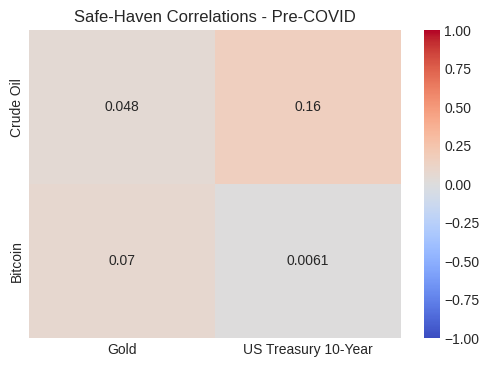


Safe-Haven Correlations During During-COVID:
               Gold  US Treasury 10-Year
Crude Oil  0.024540             0.098027
Bitcoin    0.134524             0.075279


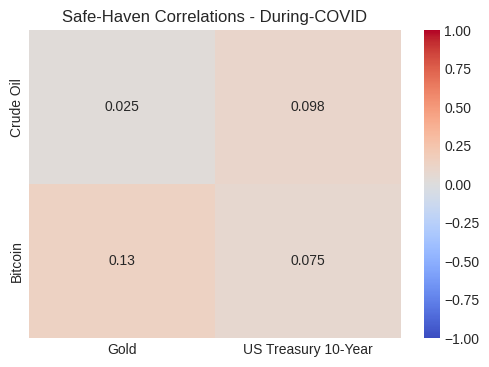


Safe-Haven Correlations During Post-COVID:
               Gold  US Treasury 10-Year
Crude Oil  0.226107             0.107365
Bitcoin    0.093018            -0.047665


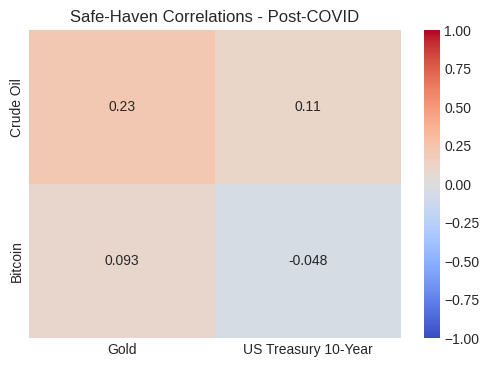

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define safe-haven assets & risky assets
safe_havens = ["Gold", "US Treasury 10-Year"]
risky_assets = ["Crude Oil", "Bitcoin"]

# Compute correlation matrices for each period
for period in returns["Period"].unique():
    corr_matrix = returns[returns["Period"] == period].drop(columns=["Period"]).corr()

    # Extract correlations of safe-haven assets to risky assets
    safe_haven_corrs = corr_matrix.loc[risky_assets, safe_havens]

    print(f"\nSafe-Haven Correlations During {period}:")
    print(safe_haven_corrs)

    # Visualize correlation shifts
    plt.figure(figsize=(6, 4))
    sns.heatmap(safe_haven_corrs, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"Safe-Haven Correlations - {period}")
    plt.show()


**Remarks:**

Comparing the correlation between Gold and US Treasury 10-year bond and between Gold versus Bitcoin prior to the pandemic era indicates low values of 0.048 and 0.07 respectively. This implies that performance of Gold was mostly independent from the performance of the two risky assets. Also, US Treasury 10-year showed low correlations with crude oil (0.16) and with bitcoin (0.0061) revealing that they are largely uncorrelated.

During the pandemic, the correlation between Gold and Bitcoin slightly increased to 0.13 implying a slight co-movement, though they correlated weakly. The correlation between US Treasury 10-year and Bitcoin slightly increased too. Additionally, gold and US Treasury 10-year maintained a weak correlation with crude oil.

Beyond the pandemic era, we observe that the correlation between Gold and Bitcoin slightly decreases to 0.093, compared to the pandemic era. This highlights gold’s weak relationship with the risky assets. Also, US Treasury 10-year displayed a slight negative correlation versus Bitcoin (-0.048). furthermore, we observe an increased correlation between gold and crude oil (0.23) suggesting a slightly stronger relationship.

To conclude, we note that gold was a good safe-haven asset across the pandemic period and afterwards. US Treasury on the other hand displayed characteristics of a safe-haven asset during the post-pandemic period. Overall, the two safe-haven assets did not display strong correlations with either Bitcoin or Crude oil during the pandemic. Therefore, the two assets can well serve as safe-haven assets during such crises.


### **Strategy 3: Stress Testing for Portfolio Resilience**

We use stress testing to simulate difficult market conditions and evaluate how well the portfolio performs during such conditions. This will help prevent excessive drawdowns by adjusting portfolio allocations. This strategy employs historical worst-case scenarios and Monte Carlo simulations in modelling potential risks.

We will implement the strategy by identifying worst historical drawdowns and assess the behavior of the portfolio. We will also backtest and assess the performance during the COVID-19 pandemic crisis.

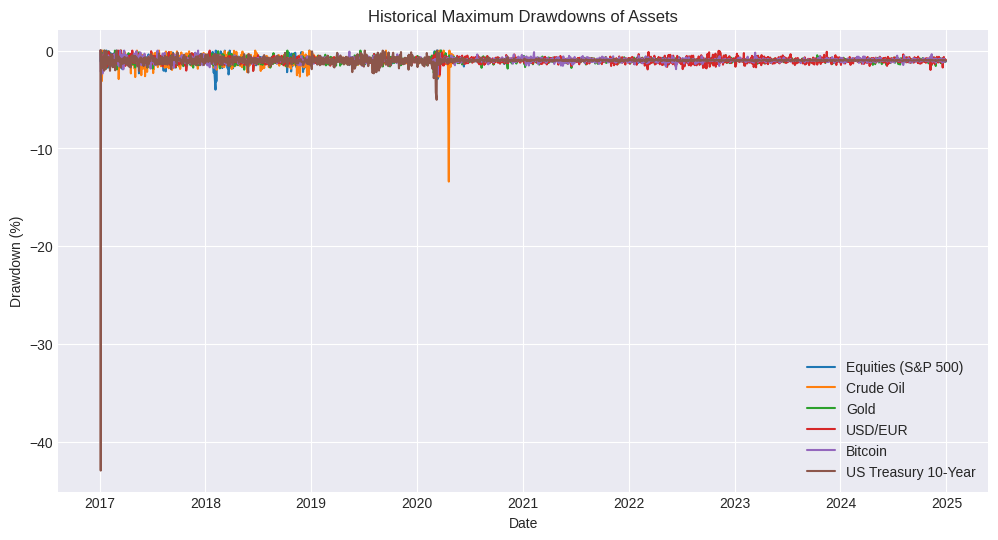

In [ ]:
# Compute historical maximum drawdowns for each asset
rolling_max = returns.drop(columns=["Period"]).cummax()
drawdowns = (returns.drop(columns=["Period"]) - rolling_max) / rolling_max

# Plot drawdowns for key assets
plt.figure(figsize=(12, 6))
for asset in returns.columns[:-1]:  # Exclude 'Period' column
    plt.plot(drawdowns.index, drawdowns[asset], label=asset)

plt.title("Historical Maximum Drawdowns of Assets")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.show()


**Remarks:**

The above graph displays the historical maximum drawdowns for the different assets under consideration. We will use this assess the resilience of the market during the pandemic crisis. Drawdown, a critical metric for assessing the downside risk of an asset by measuring the peak-to-trough asset value’s decline.

The plot reveals that there are significant drawdowns during the pandemic period. Notably, crude oil had a deep drawdown. Equally, bitcoin and equities had some significant declines. Nevertheless, gold and US-Treasury 10-year bond had relatively smaller drawdowns. Over the periods, we observe that gold and US Treasury 10-year bond experienced minimal drawdowns. Similarly, USD/EUR does not experience deep drawdowns.

We conclude from this stress test analysis that gold and US Treasury bond assets tend to be more stable during crises such as COVID-19, hence their suitability in mitigating risk during such circumstances.

**Monte Carlo Simulation for Portfolio Risk & Stress Testing**

Monte Carlo simulations are used in finance to model future risk scenarios. This is done by generating a high number of possible paths which are based on historical data. Once this is generated, it can be used to estimate portfolio returns under extreme conditions, estimate the possible extent of drawdowns and tail risks and evaluating the likelihood of extreme loss.

**Step 1: Define Monte Carlo Simulation Parameters**

To begin, we first define the parameters of the Monte Carlo simulation. To do this, we assume that the returns follow a log-normal distribution. We will also be using the historical mean and volatility to generate the simulations, where multiple runs will be done to come up with a range of possible outcomes.

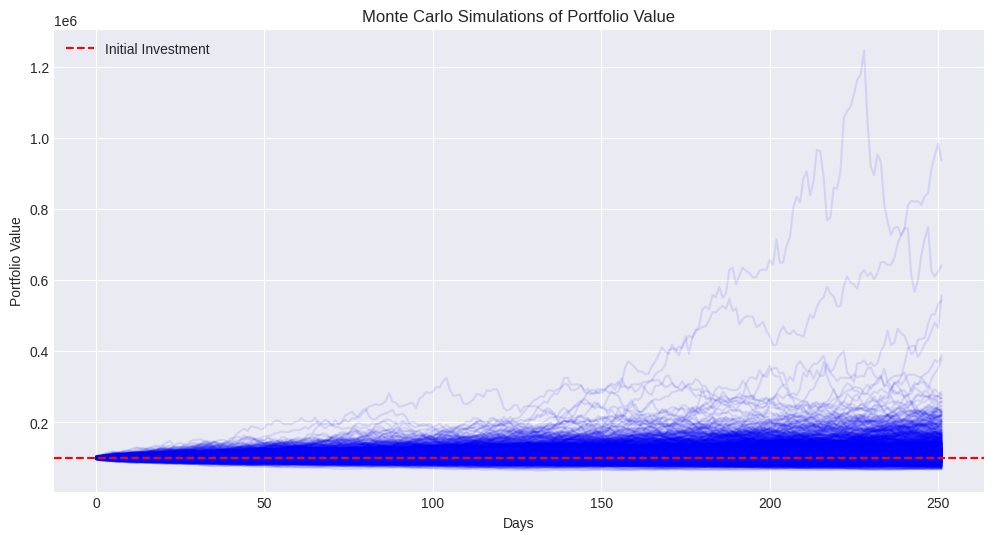

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulation Parameters
num_simulations = 1000  # Number of Monte Carlo runs
num_days = 252  # Simulating one year (trading days)
initial_investment = 100000  # Starting portfolio value

# Extract mean & volatility from historical returns
mu = returns.drop(columns=["Period"]).mean()
sigma = returns.drop(columns=["Period"]).std()

# Generate Monte Carlo simulations
simulated_portfolios = np.zeros((num_days, num_simulations))

for i in range(num_simulations):
    # Simulate daily returns using normal distribution
    daily_returns = np.random.normal(mu, sigma, (num_days, len(mu)))

    # Convert to cumulative returns
    cumulative_returns = np.cumprod(1 + daily_returns, axis=0)

    # Compute portfolio value over time
    simulated_portfolios[:, i] = initial_investment * np.sum(cumulative_returns, axis=1) / len(mu)

# Convert to DataFrame
simulated_df = pd.DataFrame(simulated_portfolios)

# Plot Monte Carlo simulations
plt.figure(figsize=(12, 6))
plt.plot(simulated_df, color="blue", alpha=0.1)
plt.title("Monte Carlo Simulations of Portfolio Value")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.axhline(y=initial_investment, color="red", linestyle="--", label="Initial Investment")
plt.legend()
plt.show()


**Step 2: Analyzing Extreme Risk Scenarios (Value at Risk - VaR)**

The VaR metric estimates the potential given a confidence level

In [ ]:
# Compute 5% percentile of portfolio value (95% confidence interval)
VaR_95 = np.percentile(simulated_df.iloc[-1, :], 5)

print(f"\n95% Value at Risk (VaR): ${initial_investment - VaR_95:,.2f}")


95% Value at Risk (VaR): $20,337.77


**Step 3: Stress Testing for Worst-Case Scenario**

Conditional Value at Risk (CVaR or Expected Shortfall) estimates expected loss beyond VaR.

In [ ]:
# Compute Conditional VaR (Expected Shortfall)
CVaR_95 = simulated_df.loc[simulated_df.index[-1], simulated_df.iloc[-1, :] <= VaR_95].mean()

print(f"\nConditional VaR (Expected Shortfall) at 95%: ${initial_investment - CVaR_95:,.2f}")


Conditional VaR (Expected Shortfall) at 95%: $24,520.65


**Remarks:**

The above plot displays multiple simulated paths for the future values of the portfolio over a 1-year period. Individual blue lines represent a single possible outcome based on random variations of the asset returns. The red line represents the initial investment, which we use to compare against the possible performance paths.

We observe that most possible paths are within a stable range, although we have some paths that indicate extreme upside potential. Comparing the paths with the initial investment, we note that most paths move around it, while some fall below the line.

The metric 95% VaR has been evaluated to be $20,337. This implies that the portfolio will not lose more than this value over a period of one year, however there is still 5% chance of experiencing larger losses than this value.

The Expected Shortfall or CvaR evaluates to $24,520. This metric represents the average loss in the worst 5% of the scenarios. Since CvaR is greater than the VaR, we can deduce that losses  can possibly exceed the VaR value during extreme market conditions.

## 7. Reporting

1. **Market Volatility**

The COVID-19 pandemic brought about significant changes in the market volatility, cutting across most asset classes. Our analysis shows that crude oil experienced a massive spike in volatility at the onset of 2020. We also noted that Bitcoin has had a high and persistent volatility across the three periods. After the pandemic, the volatility levels went down, though not below the pre-pandemic levels.

2. **Returns**

The short-term returns displayed fluctuations, intensifying during the pandemic period. However, in the long-term the return fluctuations were not statistically significant. This implies that the mean return of assets in the US financial market is resilient when we consider long period of time.

3. **Cross-Asset Correlations**

An evaluation of the correlation patterns revealed significant differences between the pre-pandemic, during and post-pandemic periods. The correlation between Bitcoin and Equities (S&P 500) increased. On the other hand, Gold and US Treasury 10-year bond retained a negative correlation, despite being weak during the pandemic period.

4. **Portfolio Risk**


Combining the asset classes under consideration to a portfolio and reviewing the portfolio risk revealed there was a sharp spike at the beginning of 2020. This spike reflects increased uncertainty in the market and the rise in correlations. At a later period, the portfolio risk went down, however it maintained levels above those of the pre-pandemic period.

5. **Statistical Significance Tests**

Applying ANOVA tests for significance in the differences in mean returns across the periods allowed us to conclude that the variations were not significant. Nonetheless, when we conducted Levene’s Test on volatility levels across the periods, we noted that there exist significant differences. Moreover, Fisher’s Z-Test on asset correlations indicated significant variations, particularly between Bitcoin and Equities (S&P 500) and between US Treasury 10-Year and Equities (S&P 500).

6. **Strategy Development**

The outcome of the analysis provides several strategies that can be employed by an investor during future market crises. We summarize these strategies as follows:

**(a). Dynamic Asset Allocation**

We observed that correlations shifted significantly across the three periods. This highlights the essence of dynamically allocating asset weights. Market conditions continually evolve, and the investors need to adjust the portfolio weights actively. Specifically, the investors can consider lessening exposure to assets that are highly correlated, instead invest more into assets with lower correlations during financial market crisis.

**(b). Risk Management**

This study has demonstrated that systemic risk increases significantly during market crises, such as the COVID-19 pandemic. Therefore, during such periods, the investors need to employ robust risk management practices. For instance, techniques such as diversification, stop loss orders and hedging can be applied to manage the risk.

**(c). Alternative Investments**

Investors need to explore alternative investments, especially during systemic crises. This is supported by the finding that assets behave uniquely when the markets experience extreme events such as the pandemic. We have observed the unique behaviors of assets such as Gold and Bitcoin during the pandemic. Considering alternative investments during crises can enhance portfolio resilience and effective portfolio diversification.

**(d). Adaptive Strategies**

The behavior of the financial markets observed after the pandemic period presents a new market environment with different characteristics, compared to prior periods. Hence, the strategies that any investor employs need to be adapted accordingly, as well as actively monitoring the market trends while reassessing the risk tolerance.

Overall, this analysis has revealed that the COVID-19 pandemic greatly shook the U.S financial markets. This is supported by the observed increases in volatility and variations in the correlation patterns over the periods. Notably, the short term mean returns were fluctuating a lot while in the long-term they remain stable. Therefore, it is critically important to actively adapt the investment strategies to effectively manage systemic risk during market crises.

In [1]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [2]:
!git add MScFECapstoneProject7872.ipynb

fatal: pathspec 'MScFECapstoneProject7872.ipynb' did not match any files
